In [1]:
# load pkgs 
import pandas as pd
import sys
import numpy as np
import os
from urllib.request import urlopen
import re
import string
import json
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('ggplot')
import seaborn as sns
from plotnine import *
from wordcloud import WordCloud 
from pyecharts.charts import Pie
from pyecharts import options as opts
import plotly.express as px

sys.path.insert(0, '/Users/akhilvelamati/Downloads/AdvDS-Analysis-master/venv/lib/python3.9/site-packages')
import pymysql
from bs4 import BeautifulSoup

# Machine Learning pkgs
from sklearn import preprocessing, metrics, neighbors, model_selection, svm, ensemble
import xgboost as xgb

In [2]:
# load helper functions from ../Codebase
sys.path.insert(0, '../Codebase/')
from db_utils import YelpDb
from helper_fe import *
from ratdist_plot import RatdistPlot
from category_plot import CategoryPlot
from ophrs_plot import OpHrsPlot
from helper_ml import *

In [3]:
# Resource 1:
# open url connection 
from urllib.request import urlopen
link = 'https://patch.com/california/lajolla/ca-cities-rank-among-best-big-cities-live'
html = urlopen(link).read()
soup = BeautifulSoup(html, features='html')
print(soup.text)
# use class to narrow search, based on observation 
target_level = soup.find('section', {"class": "page__content"})
target_level_2 = target_level.find_all('ol')[1]
target_level_3 = target_level_2.find_all('li')
cali_cities = []
token_list = []
for info in target_level_3:
    cali_cities.append(info.get_text(strip=True))
for i in cali_cities:
    flag = re.findall("[A-Za-z ]", i)
    if flag:
        token = "".join(flag)
        token_list.append(token)
print(f'The list of best big cities in California are: {token_list[:12]}')

CA Cities Rank Among Best Big Cities To Live In | La Jolla, CA PatchSkip to main contentLa Jolla, CASubscribeNews FeedEventsLocal BusinessesClassifiedsPostAdvertiseNearbyDel Mar-Carmel Valley NewsSan Diego NewsCoronado NewsEncinitas NewsLemon Grove NewsRancho Bernardo-4s Ranch NewsSantee NewsLa Mesa-Mount Helix NewsPoway NewsCarlsbad NewsLocal NewsCommunity CornerCrime & SafetyPolitics & GovernmentSchoolsTraffic & TransitObituariesPersonal FinanceNeighbor NewsBest OfSeasonal & HolidaysWeatherArts & EntertainmentBusiness & TechHealth & WellnessHome & GardenSportsTravelKids & FamilyPetsRestaurants & BarsLocalStreamEventsLocal BusinessesClassifiedsReal EstateReal Estate ListingsReal Estate NewsSee all communitiesAdvertiseNearby CommunitiesDel Mar-Carmel Valley, CASan Diego, CACoronado, CAEncinitas, CALemon Grove, CARancho Bernardo-4s Ranch, CASantee, CALa Mesa-Mount Helix, CAPoway, CACarlsbad, CAState EditionCaliforniaNational EditionTop National NewsSee All CommunitiesCommunity CornerCA 

In [4]:
# Resource 2:
link = 'https://en.wikipedia.org/wiki/List_of_largest_California_cities_by_population'
html = urlopen(link).read()

soup = BeautifulSoup(html, features="html")
cities = []
table = soup.find('table', {"class": "wikitable sortable"})
rows = table.find_all("tr")
for row in rows[1:]:
    city = row.find_all("td")[1].get_text(strip=True)
    cities.append(city)
print(f'The list of top 12 cities with most populations in California are: {cities[:12]}')

The list of top 12 cities with most populations in California are: ['Los Angeles', 'San Diego', 'San Jose', 'San Francisco', 'Fresno', 'Sacramento', 'Long Beach', 'Oakland', 'Bakersfield', 'Anaheim', 'Stockton', 'Riverside']


In [5]:
# build DB connections from mysql server 
yelp_db_group = YelpDb("yelp_db")  # cities 1-12 (sourced multiple databases)

# show tables
sql_tabs = "show TABLES;"
yelp_db_group.execute(sql_tabs)
yelp_db_group.fetch_all()

(('yelp_Anaheim',),
 ('yelp_Anaheim_reviews',),
 ('yelp_Bakersfield',),
 ('yelp_Bakersfield_reviews',),
 ('yelp_Fresno',),
 ('yelp_Fresno_reviews',),
 ('yelp_Long_Beach',),
 ('yelp_Long_Beach_reviews',),
 ('yelp_Los_Angeles',),
 ('yelp_Los_Angeles_reviews',),
 ('yelp_Oakland',),
 ('yelp_Oakland_reviews',),
 ('yelp_Riverside',),
 ('yelp_Riverside_reviews',),
 ('yelp_Sacramento',),
 ('yelp_Sacramento_reviews',),
 ('yelp_San_Diego',),
 ('yelp_San_Diego_reviews',),
 ('yelp_San_Francisco',),
 ('yelp_San_Francisco_reviews',),
 ('yelp_San_Jose',),
 ('yelp_San_Jose_reviews',),
 ('yelp_Santa_Ana',),
 ('yelp_Santa_Ana_reviews',))

In [6]:
# Table 1
yelp_df_la = yelp_db_group.db_to_df("yelp_Los_Angeles")
yelp_df_la.sample(1)

Name                                  Address  \
47  Cento  4921 W Adams Blvd Los Angeles, CA 90016   

                                      Category Price         Rating Reviews  \
47  Italian, Mediterranean, Tapas/Small Plates    $$  (725 reviews)     4.5   

                   Mon                 Tue                 Wed  \
47  5:00 PM - 10:00 PM  5:00 PM - 10:00 PM  5:00 PM - 10:00 PM   

                   Thu                 Fri                 Sat  \
47  5:00 PM - 10:00 PM  5:00 PM - 11:00 PM  5:00 PM - 11:00 PM   

                   Sun  
47  5:00 PM - 10:00 PM

In [7]:
# Table 2
yelp_df_sd = yelp_db_group.db_to_df("yelp_san_diego")
yelp_df_sd.sample(1)

Name                            Address           Category  \
88  Sushi Yorimichi  2405 Ulric St San Diego, CA 92111  Sushi Bars, Ramen   

   Price         Rating Reviews                 Mon                 Tue  \
88    $$  (251 reviews)     4.5  11:00 AM - 8:30 PM  11:00 AM - 8:30 PM   

                   Wed                 Thu                 Fri  \
88  11:00 AM - 8:30 PM  11:00 AM - 8:30 PM  11:00 AM - 9:30 PM   

                   Sat                 Sun  
88  11:00 AM - 9:30 PM  11:00 AM - 8:30 PM

In [8]:
# Table 3
yelp_df_sj = yelp_db_group.db_to_df("yelp_san_jose")
yelp_df_sj.sample(1)

Name                                  Address       Category  \
66  Sam and Curry  1751 N 1st St Ste 40 San Jose, CA 95112  Indian, Halal   

   Price         Rating Reviews                 Mon                 Tue  \
66    $$  (617 reviews)     4.7  11:00 AM - 9:00 PM  11:00 AM - 9:00 PM   

                   Wed                 Thu                 Fri  \
66  11:00 AM - 9:00 PM  11:00 AM - 9:00 PM  11:00 AM - 9:00 PM   

                   Sat                 Sun  
66  11:00 AM - 9:00 PM  11:00 AM - 8:00 PM

In [9]:
# Table 4
yelp_df_sf = yelp_db_group.db_to_df("yelp_San_Francisco")
yelp_df_sf.sample(1)

Name                               Address                Category  \
211  Sotto Mare  552 Green St San Francisco, CA 94133  Seafood, Italian, Bars   

    Price           Rating Reviews                 Mon                 Tue  \
211    $$  (5,260 reviews)     4.3  11:30 AM - 9:00 PM  11:30 AM - 9:00 PM   

                    Wed                 Thu                  Fri  \
211  11:30 AM - 9:00 PM  11:30 AM - 9:00 PM  11:30 AM - 10:00 PM   

                     Sat                 Sun  
211  11:30 AM - 10:00 PM  11:30 AM - 9:00 PM

In [10]:
# Table 5
yelp_df_fr = yelp_db_group.db_to_df("yelp_fresno")
yelp_df_fr.sample(1)

Name                                Address  \
130  Trelio Food & Wine  438 Clovis Ave Ste 4 Clovis, CA 93612   

                                              Category Price         Rating  \
130  New American, Modern European, Breakfast & Brunch   $$$  (367 reviews)   

    Reviews     Mon                Tue                Wed                Thu  \
130     4.4  Closed  5:00 PM - 8:00 PM  5:00 PM - 8:00 PM  5:00 PM - 8:00 PM   

                   Fri                Sat                Sun  
130  5:00 PM - 8:30 PM  5:00 PM - 8:30 PM  5:00 PM - 7:00 PM

In [11]:
# Table 6
yelp_df_sc = yelp_db_group.db_to_df("yelp_sacramento")
yelp_df_sc.sample(1)

Name                                  Address  \
96  Sarom's Southern Kitchen  1901 El Camino Ave Sacramento, CA 95815   

                                   Category Price           Rating Reviews  \
96  Southern, Soul Food, Breakfast & Brunch    $$  (1,404 reviews)     4.3   

                  Mon                Tue     Wed                Thu  \
96  7:00 AM - 3:00 PM  7:00 AM - 3:00 PM  Closed  7:00 AM - 3:00 PM   

                  Fri                Sat                Sun  
96  7:00 AM - 3:00 PM  7:00 AM - 4:00 PM  7:00 AM - 4:00 PM

In [12]:
# Table 7
yelp_df_lb = yelp_db_group.db_to_df("yelp_Long_Beach")
yelp_df_lb.sample(1)

Name                                 Address  \
164  Black Bear Diner - Signal Hill  1898 E Willow St Signal Hill, CA 90755   

                                 Category Price           Rating Reviews  \
164  American, Diners, Breakfast & Brunch    $$  (1,139 reviews)     3.6   

                    Mon                 Tue                 Wed  \
164  6:00 AM - 10:00 PM  6:00 AM - 10:00 PM  6:00 AM - 10:00 PM   

                    Thu                 Fri                 Sat  \
164  6:00 AM - 10:00 PM  6:00 AM - 10:00 PM  6:00 AM - 10:00 PM   

                    Sun  
164  6:00 AM - 10:00 PM

In [13]:
# Table 8
yelp_df_ok = yelp_db_group.db_to_df("yelp_Oakland")
yelp_df_ok.sample(1)

Name                               Address  \
122  Hometown Heroes East Bay  4000 Adeline St Emeryville, CA 94608   

                              Category Price         Rating Reviews  \
122  American, Sports Bars, Sandwiches    $$  (204 reviews)     4.3   

                               Mon                            Tue  \
122  4:00 PM - 12:00 AM (Next day)  4:00 PM - 12:00 AM (Next day)   

                               Wed                           Thu  \
122  4:00 PM - 12:00 AM (Next day)  4:00 PM - 1:30 AM (Next day)   

                              Fri                            Sat  \
122  4:00 PM - 1:30 AM (Next day)  10:00 AM - 1:30 AM (Next day)   

                                Sun  
122  10:00 AM - 12:00 AM (Next day)

In [14]:
# Table 9
yelp_df_bf = yelp_db_group.db_to_df("yelp_Bakersfield")
yelp_df_bf.sample(1)

Name                             Address Category Price  \
55  Rancho Grande  6348 Ashe Rd Bakersfield, CA 93313  Mexican    $$   

          Rating Reviews                 Mon                 Tue  \
55  (94 reviews)     4.2  10:00 AM - 9:00 PM  10:00 AM - 9:00 PM   

                   Wed                 Thu                  Fri  \
55  10:00 AM - 9:00 PM  10:00 AM - 9:00 PM  10:00 AM - 10:00 PM   

                  Sat                Sun  
55  9:00 AM - 9:00 PM  9:00 AM - 9:00 PM

In [15]:
# Table 10
yelp_df_ah = yelp_db_group.db_to_df("yelp_Anaheim")
yelp_df_ah.sample(1)

Name                                     Address  \
66  Spice Social  138 W Commonwealth Ave Fullerton, CA 92832   

                       Category Price         Rating Reviews     Mon  \
66  Indian, Halal, Asian Fusion    $$  (264 reviews)     4.5  Closed   

                   Tue                 Wed                 Thu  \
66  11:00 AM - 3:00 PM  11:00 AM - 3:00 PM  11:00 AM - 3:00 PM   

                   Fri                 Sat                 Sun  
66  11:00 AM - 3:00 PM  11:00 AM - 3:00 PM  11:00 AM - 3:00 PM

In [16]:
# Table 11
yelp_df_sa = yelp_db_group.db_to_df("yelp_Santa_Ana")
yelp_df_sa.sample(1)

Name Address Category Price Rating Reviews   Mon   Tue   Wed   Thu   Fri  \
162  None    None           None   None    None  None  None  None  None  None   

      Sat   Sun  
162  None  None

In [17]:
# Table 12
yelp_df_rs = yelp_db_group.db_to_df("yelp_Riverside")
yelp_df_rs.sample(1)

Name                                        Address  \
147  Royal Orchid Thai II  1450 University Ave Ste M Riverside, CA 92507   

    Category Price         Rating Reviews                 Mon  \
147     Thai    $$  (439 reviews)     4.2  11:00 AM - 3:00 PM   

                    Tue                 Wed                 Thu  \
147  11:00 AM - 3:00 PM  11:00 AM - 3:00 PM  11:00 AM - 3:00 PM   

                    Fri                 Sat                 Sun  
147  11:00 AM - 3:00 PM  11:00 AM - 3:00 PM  11:00 AM - 3:00 PM

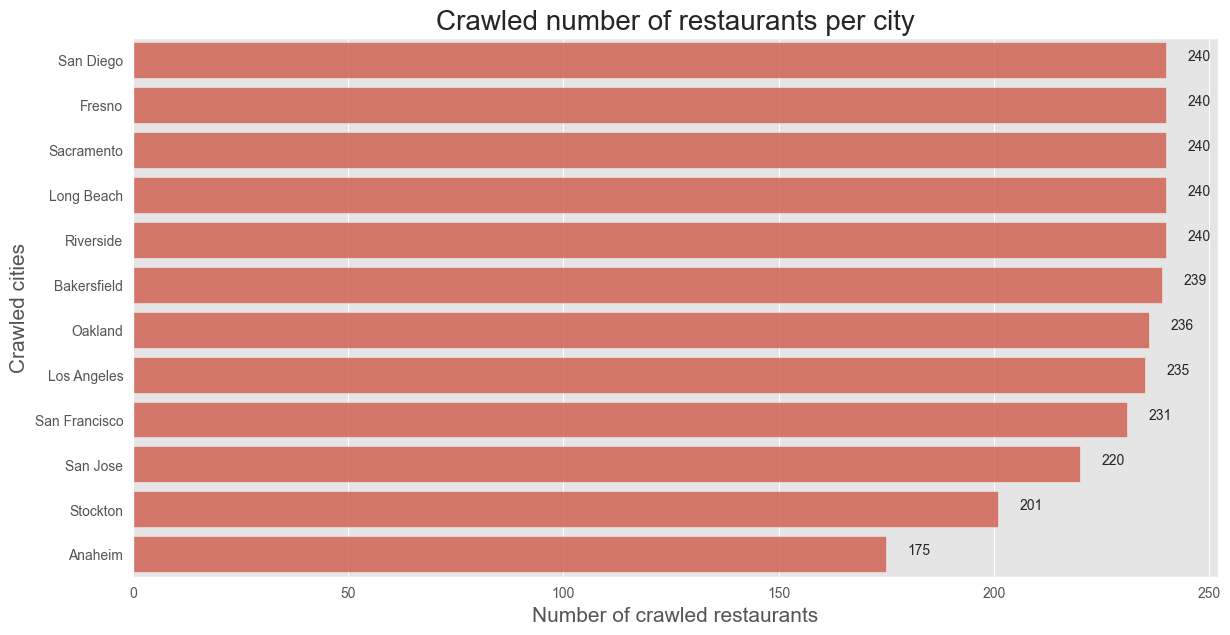

In [18]:
city_list = cities[:12]
rstats_list = [yelp_df_la.shape[0], yelp_df_sd.shape[0], yelp_df_sj.shape[0], yelp_df_sf.shape[0],
               yelp_df_fr.shape[0], yelp_df_sc.shape[0], yelp_df_lb.shape[0], yelp_df_ok.shape[0],
               yelp_df_bf.shape[0], yelp_df_ah.shape[0], yelp_df_sa.shape[0], yelp_df_rs.shape[0]]
comp_dict = {"Cities": city_list, "Restaurants_number": rstats_list}
comp_df = pd.DataFrame(data=comp_dict).sort_values("Restaurants_number", ascending=False)

plt.figure(figsize=(14, 7))
ax = sns.barplot(x=comp_df.Restaurants_number, y=comp_df.Cities, alpha=0.8)
plt.title("Crawled number of restaurants per city", fontsize=20)
plt.ylabel('Crawled cities', fontsize=15)
plt.xlabel('Number of crawled restaurants', fontsize=15)

# adding the text labels
rects = ax.patches 
labels = comp_df.Restaurants_number.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() + 5, height/2 + rect.get_y(), label, ha='left')
plt.show()

In [19]:
# Data concatenation
yelp_df_all = pd.concat([yelp_df_la, yelp_df_sd, yelp_df_sj, yelp_df_sf,
                        yelp_df_fr, yelp_df_sc, yelp_df_lb, yelp_df_ok,
                        yelp_df_bf, yelp_df_ah, yelp_df_sa, yelp_df_rs]).reset_index(drop=True)
print(f'Yelp data for all cities: number of rows (restaurants) = {yelp_df_all.shape[0]}')
print(f'number of columns (features) = {yelp_df_all.shape[1]}')
yelp_df_all.sample(3)

Yelp data for all cities: number of rows (restaurants) = 2737
number of columns (features) = 13


Name                                           Address  \
106   Cooking Mom  3660 Wilshire Blvd Ste 120 Los Angeles, CA 90010   
2658  loud burger           22497 Barton Rd Grand Terrace, CA 92313   
1691     Lovely's                 2344 Webster St Oakland, CA 94612   

                          Category Price         Rating Reviews  \
106   Korean, Specialty Food, Soup    $$   (36 reviews)     4.8   
2658                       Burgers    $$  (191 reviews)     4.5   
1691      Burgers, Diners, Seafood    $$  (226 reviews)     4.2   

                     Mon                 Tue                 Wed  \
106   10:00 AM - 5:30 PM  10:00 AM - 5:30 PM  10:00 AM - 5:30 PM   
2658  11:00 AM - 8:00 PM  11:00 AM - 8:00 PM  11:00 AM - 8:00 PM   
1691              Closed              Closed   4:00 PM - 9:30 PM   

                     Thu                 Fri                 Sat  \
106   10:00 AM - 5:30 PM  10:00 AM - 5:30 PM              Closed   
2658  11:00 AM - 8:00 PM  11:00 AM - 8:00 PM  11:00 AM - 5:00 PM   
1691   4:00 PM - 9:30 PM  4:00 PM - 10:00 PM  4:00 PM - 10:00 PM   

                     Sun  
106               Closed  
2658  12:00 PM - 4:00 PM  
1691  12:00 PM - 4:30 PM

In [20]:
# drop duplicates data based on Name as primary key
yelp_df_all = yelp_df_all.drop_duplicates()
yelp_df_all = yelp_df_all.reset_index()

In [21]:
# fill NAN
exceptions(yelp_df_all, verbose=True)
yelp_clean_df = yelp_df_all.applymap(find_null)

No exceptions detected


In [107]:
# feature engineering on open hours 
#parking_type=['street', 'lot', 'garage', 'valet']

# yelp_clean_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 
#                'Sun']] = yelp_clean_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].applymap(get_open_time)
# #yelp_clean_df[parking_type] = yelp_clean_df.Parking.apply(get_parking)  # create four new features 

yelp_clean_df[['MonOpen', 'TueOpen', 'WedOpen', 'ThuOpen', 'FriOpen', 'SatOpen', 
               'SunOpen']] = yelp_clean_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 
                                            'Sat', 'Sun']].applymap(OpeningTime)  # 7 new features

yelp_clean_df[['MonClose', 'TueClose', 'WedClose', 'ThuClose', 'FriClose', 'SatClose', 
               'SunClose']] = yelp_clean_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 
                                            'Sat', 'Sun']].applymap(ClosingTime)  # 7 new features

Actual string [['11:30 AM ', ' 9:00 PM']]
time_str: ['11:30', 'AM']
Opening component: <class 'str'>
Actual string [['8:00 AM ', ' 10:00 PM']]
time_str: ['8:00', 'AM']
Opening component: <class 'str'>
Actual string [['4:00 PM ', ' 10:00 PM']]
time_str: ['4:00', 'PM']
Opening component: <class 'str'>
Actual string [['4:00 PM ', ' 12:00 AM (Next day)']]
time_str: ['4:00', 'PM']
Opening component: <class 'str'>
Actual string [['8:00 AM ', ' 2:00 PM']]
time_str: ['8:00', 'AM']
Opening component: <class 'str'>
Actual string [['10:00 AM ', ' 9:00 PM']]
time_str: ['10:00', 'AM']
Opening component: <class 'str'>
Actual string [['3:00 PM ', ' 1:00 AM (Next day)']]
time_str: ['3:00', 'PM']
Opening component: <class 'str'>
Actual string [['11:00 AM ', ' 3:00 PM']]
time_str: ['11:00', 'AM']
Opening component: <class 'str'>
Actual string [['11:30 AM ', ' 3:00 PM']]
time_str: ['11:30', 'AM']
Opening component: <class 'str'>
Actual string [[0, 24]]
time_str: ['0']
Opening component: <class 'str'>
Act

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [109]:
yelp_clean_df[['TueClose']].shape

(2604, 1)

In [78]:
def OpeningTime(time_str):
    if time_str == None:
        return None
    if time_str == 'Closed':
         return 'Closed'
    print("Actual string", time_str)
    components = str(time_str[0][0]).split()
    print("time_str:",components)
    print("Opening component:",type(components[0]))
    # Extract the hour and minute
    opening_hour_component = str(components[0]).split(':')
    if len(opening_hour_component) != 2:
        return "Closed"
    opening_hour, opening_minute = map(int, opening_hour_component)

    # Convert to 24-hour format if PM
    if 'PM' in components[1] and opening_hour != 12:
        opening_hour += 12
    opening_minute = opening_minute if opening_minute != 0 else '00'
    # Return the opening hour and minute in 24-hour format
    return str(opening_hour)+":"+str(opening_minute)

# Example usage:
time_str = [['3:00 PM - 9:30 PM']]
hour_24_format = OpeningTime(time_str)
print(hour_24_format)  # Output: 15


Actual string [['3:00 PM - 9:30 PM']]
time_str: ['3:00', 'PM', '-', '9:30', 'PM']
Opening component: <class 'str'>
15:00


In [103]:
def ClosingTime(time_str):
    if time_str == None or time_str=="Unknown":
        return 'No Info'
    if time_str == 'Closed':
        return 'Closed'

    # Split the time string into components
    print("Actual string", time_str)
    components = str(time_str[0][1]).split()
    print("time_str:",components)
    print("closing component:",components[0])
  
    # Extract the hour and minute
    closing_hour_component = str(components[0]).split(':')
    if len(closing_hour_component) != 2:
        return "Closed"
    closing_hour, closing_minute = map(int, closing_hour_component)

    # Convert to 24-hour format if PM
    if 'PM' in components[1] and closing_hour != 12:
        closing_hour += 12
    closing_minute = closing_minute if closing_minute != 0 else '00'
    # Return the closing hour and minute in 24-hour format
    return str(closing_hour)+":"+str(closing_minute)

# Example usage:
time_str = [['9:00 PM ','10:30 PM']]
closing_hour_24 = ClosingTime(time_str)
print(closing_hour_24)  # Output: Closing hour: 22, Closing minute: 30


Actual string [['9:00 PM ', '10:30 PM']]
time_str: ['10:30', 'PM']
closing component: 10:30
22:30


In [110]:
yelp_clean_df['ZIP'] = yelp_clean_df.Address.apply(get_ZIP)

In [111]:
yelp_clean_df['ZIP']

0        CA 90048
1        CA 90004
2        CA 90036
3        CA 90020
4        CA 90036
          ...    
2599     CA 92505
2600     CA 92504
2601     CA 92501
2602     CA 92501
2603     CA 92507
Name: ZIP, Length: 2604, dtype: object

In [119]:
print(yelp_clean_df.Reviews.value_counts())

Reviews
4.3                   319
4.4                   294
4.5                   257
4.2                   233
4.1                   205
4.0                   192
4.6                   191
3.9                   173
4.7                   170
3.8                   132
4.8                   110
5.0                    59
4.9                    52
3.7                    45
3.5                    43
3.6                    41
3.4                    23
3.3                    17
3.2                    12
3.1                    10
,                       5
3.0                     4
2.9                     4
2.5                     3
2.6                     2
Unknown                 1
2.3                     1
2.4                     1
2.7                     1
1.6                     1
11:00 AM - 9:00 PM      1
2.2                     1
9:00 AM - 10:00 PM      1
Name: count, dtype: int64


In [120]:
class RatdistPlot:
    def __init__(self, df):
        self.df = df
        
    def plot(self, font_size, title):
        """Make ratings distribution plot"""
        counts = self.df['Reviews'].value_counts().sort_index()
        ax = sns.barplot(x=counts.index, y=counts.values, alpha=0.8)
        plt.title(title, fontsize=font_size)
        plt.xlabel("Ratings", fontsize=font_size)
        plt.ylabel("Number of Hotels", fontsize=font_size)

        # Add text labels
        for rect, count in zip(ax.patches, counts.values):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height + 5, count,
                    ha='center', va='bottom')
            
    def clean_each_city_df(self):
        exceptions(self.df)
        clean_df = self.df.applymap(find_null)
        return clean_df


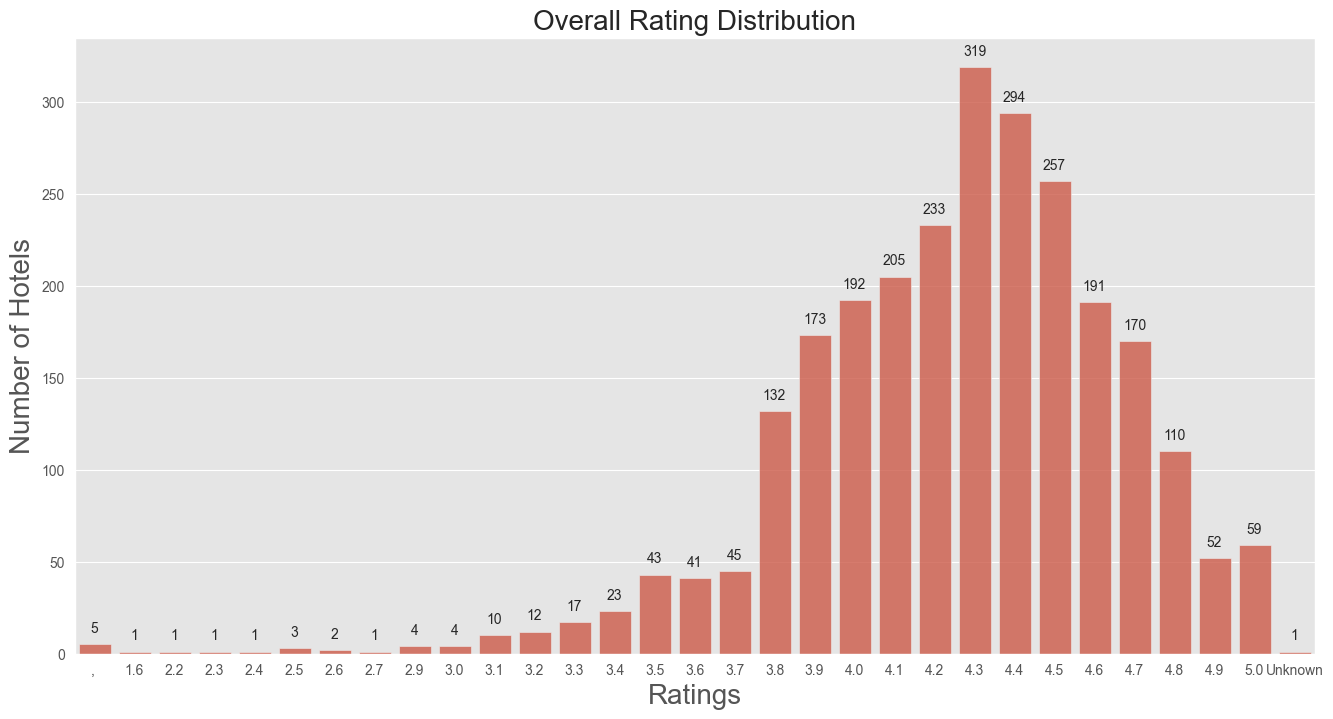

In [129]:
# Overall Rating Distribution
plt.figure(figsize=(16, 8))
ratdist = RatdistPlot(yelp_clean_df)
ratdist.plot(20, "Overall Rating Distribution")

In [127]:
value_to_remove = '9:00 AM - 10:00 PM'
column_name = 'Reviews'
yelp_clean_df = yelp_clean_df[yelp_clean_df[column_name] != value_to_remove]


In [128]:
yelp_clean_df.shape

(2602, 29)

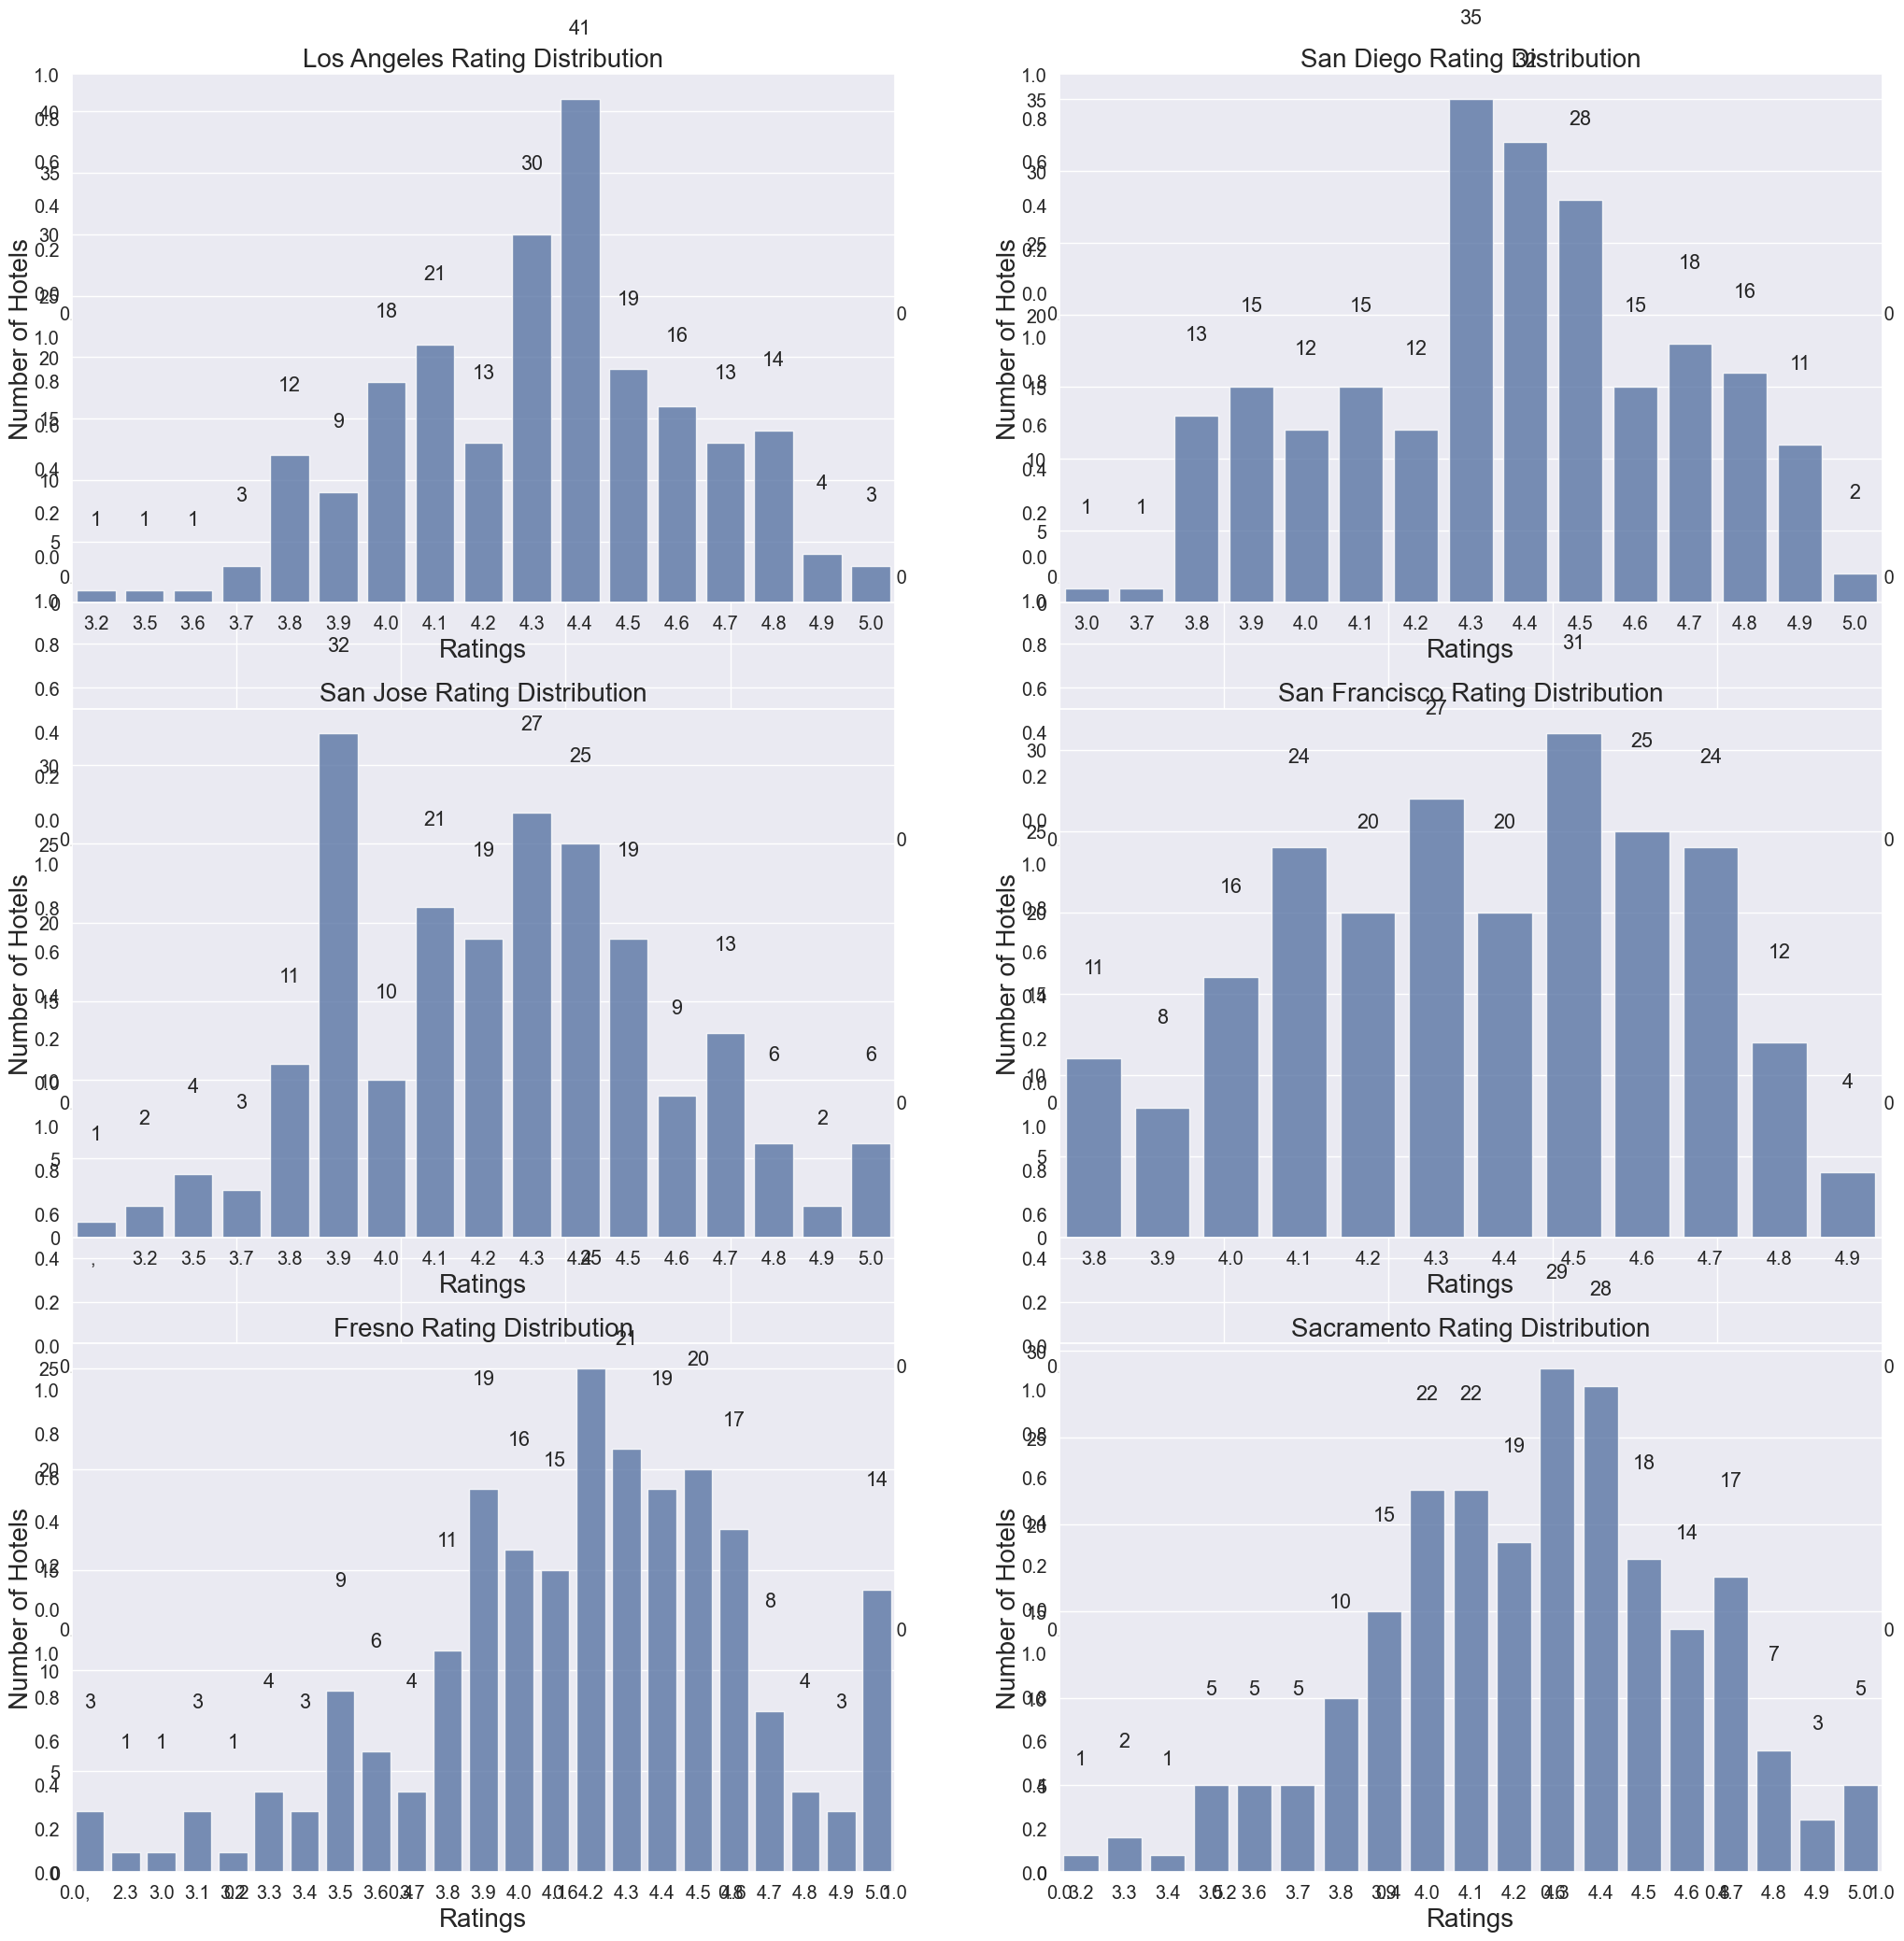

In [132]:
sns.set(rc={'figure.figsize':(25,25)})
sns.set(font_scale=1.3)

# Create a figure and axes with specified number of rows and columns
fig, axes = plt.subplots(7, 2)
# Los Angeles
plt.subplot(321)
ratdist = RatdistPlot(yelp_df_la)
clean_yelp_df_la = ratdist.clean_each_city_df()
ratdist.plot(20, "Los Angeles Rating Distribution")

# San Diego
plt.subplot(322)
ratdist = RatdistPlot(yelp_df_sd)
clean_yelp_df_sd = ratdist.clean_each_city_df()
ratdist.plot(20, "San Diego Rating Distribution")

# San Jose
plt.subplot(323)
ratdist = RatdistPlot(yelp_df_sj)
clean_yelp_df_sj = ratdist.clean_each_city_df()
ratdist.plot(20, "San Jose Rating Distribution")

# San Francisco
plt.subplot(324)
ratdist = RatdistPlot(yelp_df_sf)
clean_yelp_df_sf = ratdist.clean_each_city_df()
ratdist.plot(20, "San Francisco Rating Distribution")

# Fresno
plt.subplot(325)
ratdist = RatdistPlot(yelp_df_fr)
clean_yelp_df_fr = ratdist.clean_each_city_df()
ratdist.plot( 20, "Fresno Rating Distribution")

# Sacramento
plt.subplot(326)
ratdist = RatdistPlot(yelp_df_sc)
clean_yelp_df_sc = ratdist.clean_each_city_df()
ratdist.plot(20, "Sacramento Rating Distribution")
# 
# plt.subplot(327)
# ratdist = RatdistPlot(yelp_df_ah)
# clean_yelp_df_ah = ratdist.clean_each_city_df()
# ratdist.plot(20, "Anahiem Rating Distribution")
# 
# plt.subplot(328)
# ratdist = RatdistPlot(yelp_df_bf)
# clean_yelp_df_bf = ratdist.clean_each_city_df()
# ratdist.plot(20, "Bakersfield Rating Distribution")
# 
# plt.subplot(329)
# ratdist = RatdistPlot(yelp_df_rs)
# clean_yelp_df_rs = ratdist.clean_each_city_df()
# ratdist.plot(20, "Riverside Rating Distribution")
# 
# plt.subplot(330)
# ratdist = RatdistPlot(yelp_df_ok)
# clean_yelp_df_ok = ratdist.clean_each_city_df()
# ratdist.plot(20, "Oakland Rating Distribution")
# 
# plt.subplot(331)
# ratdist = RatdistPlot(yelp_df_sa)
# clean_yelp_df_sa = ratdist.clean_each_city_df()
# ratdist.plot(20, "Santa Ana Rating Distribution")
# 
# plt.subplot(332)
# ratdist = RatdistPlot(yelp_df_lb)
# clean_yelp_df_lb = ratdist.clean_each_city_df()
# ratdist.plot(20, "Long Beach Rating Distribution")

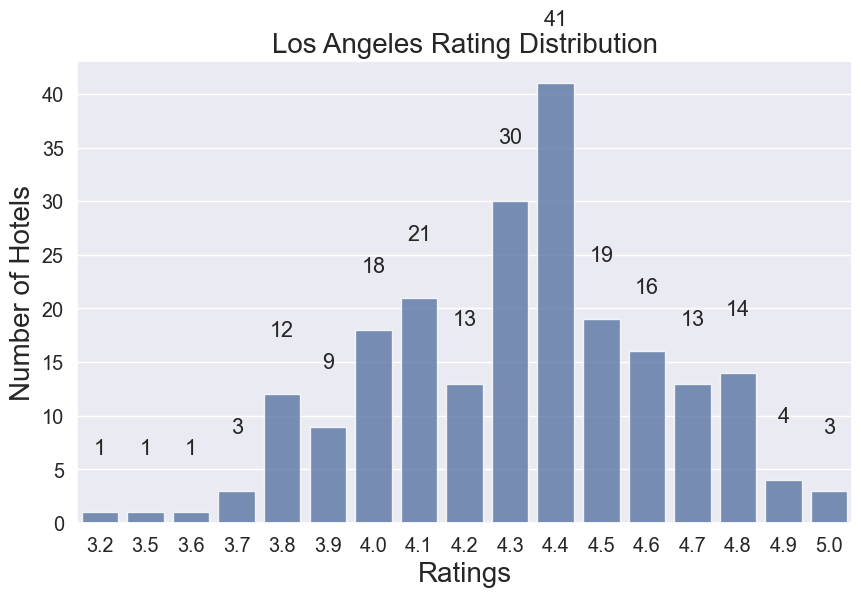

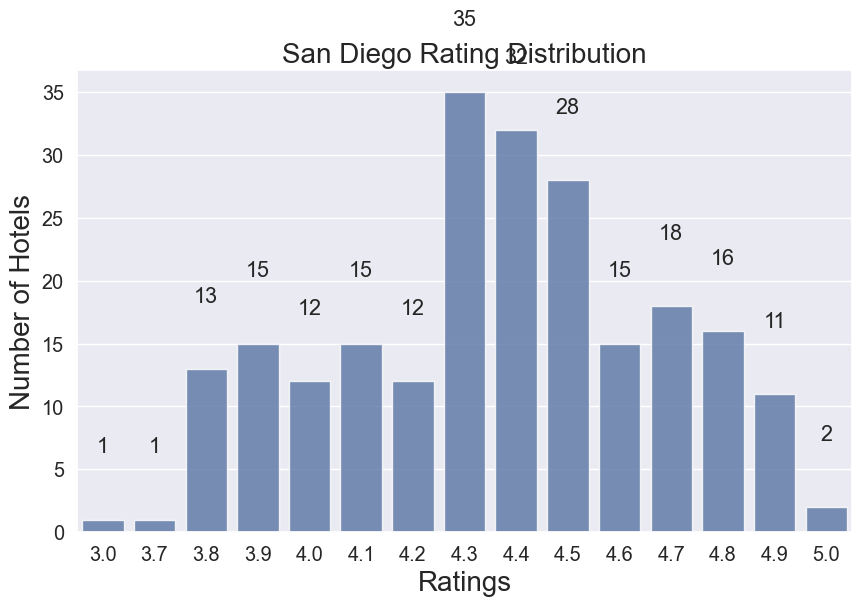

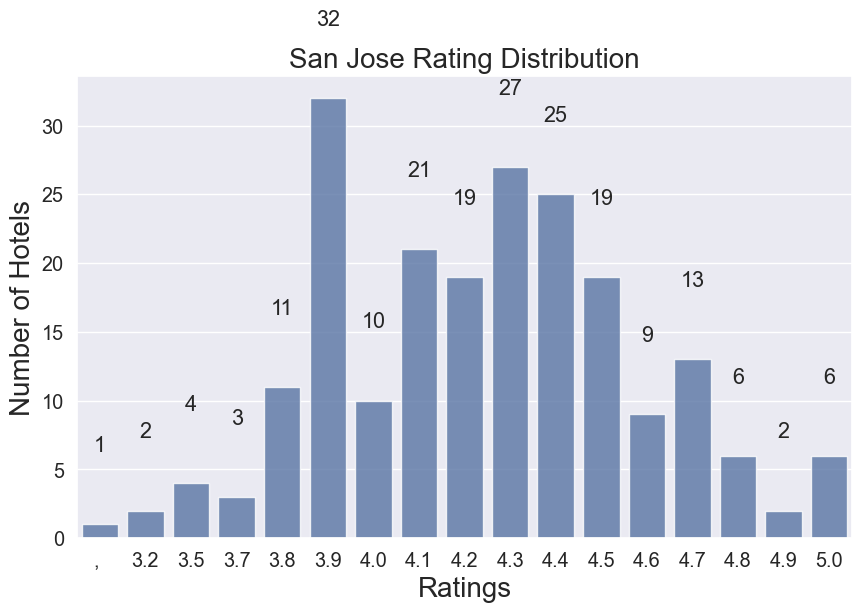

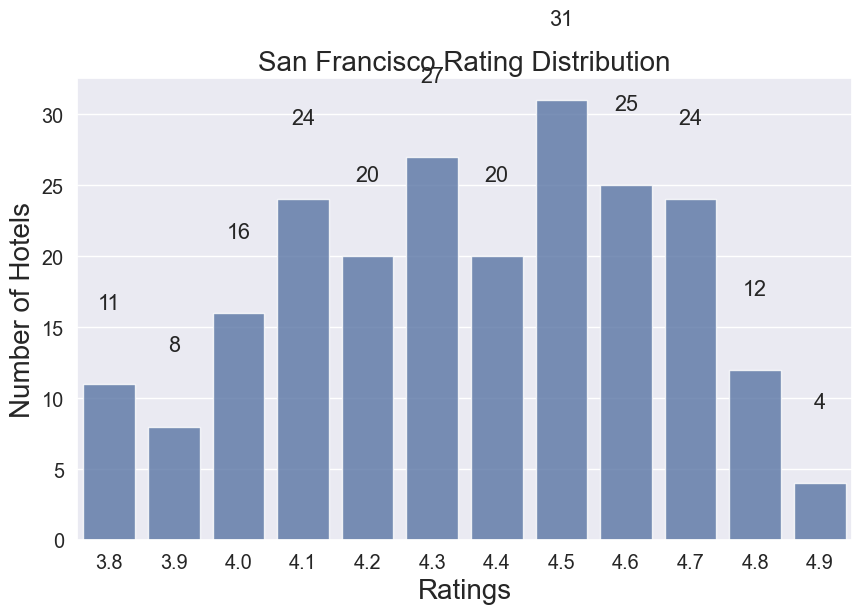

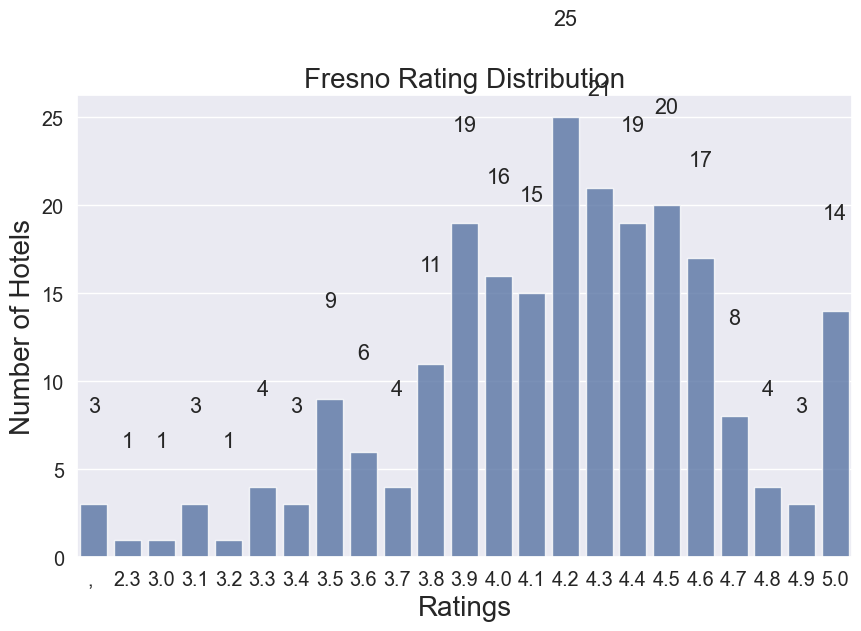

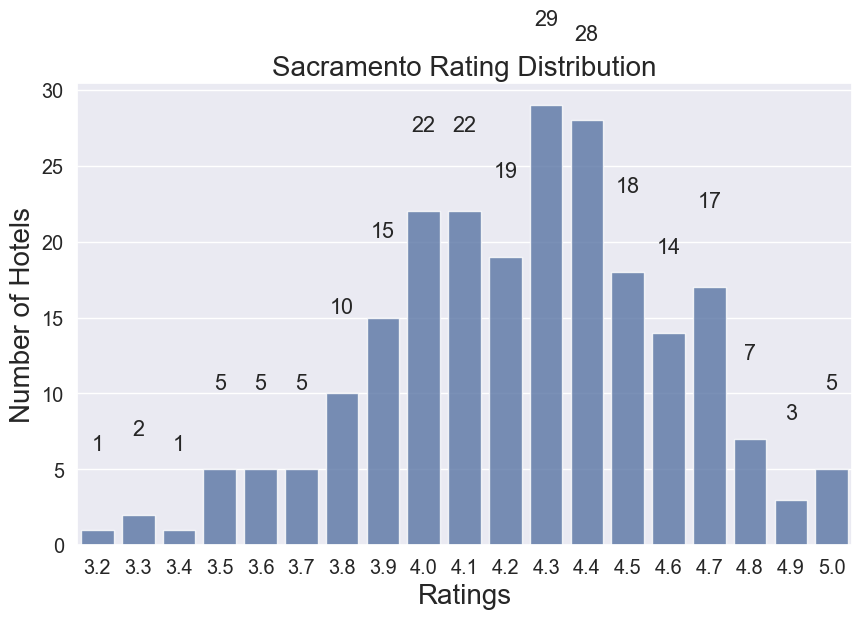

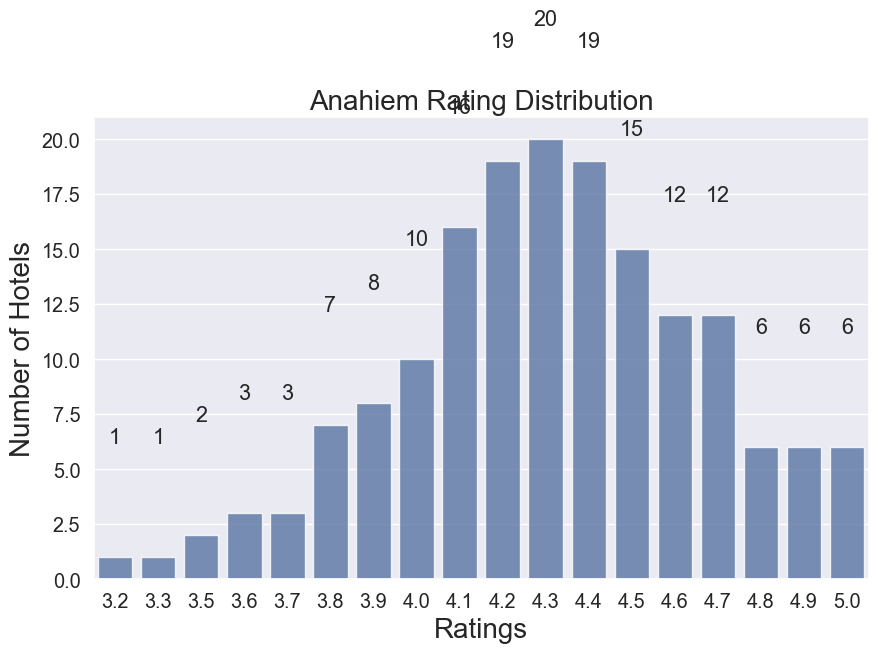

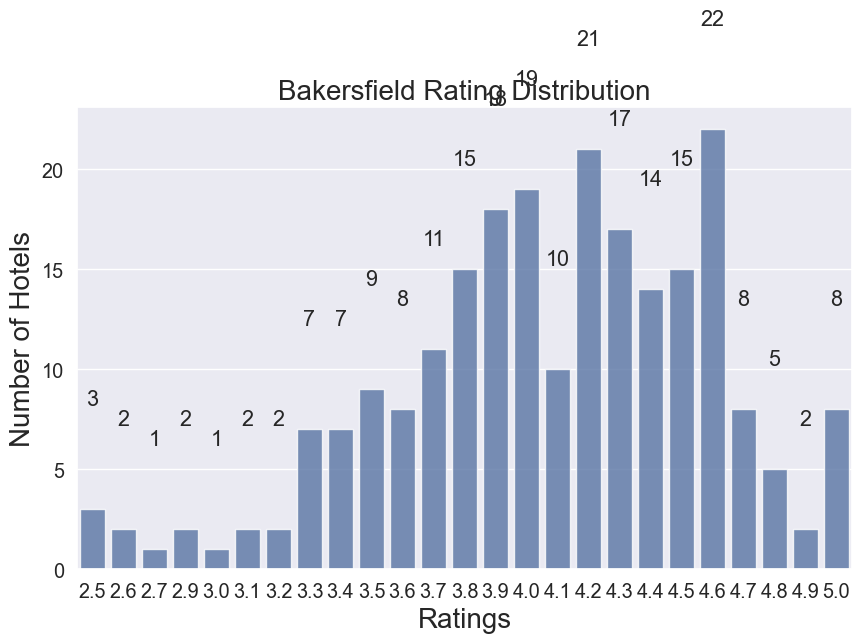

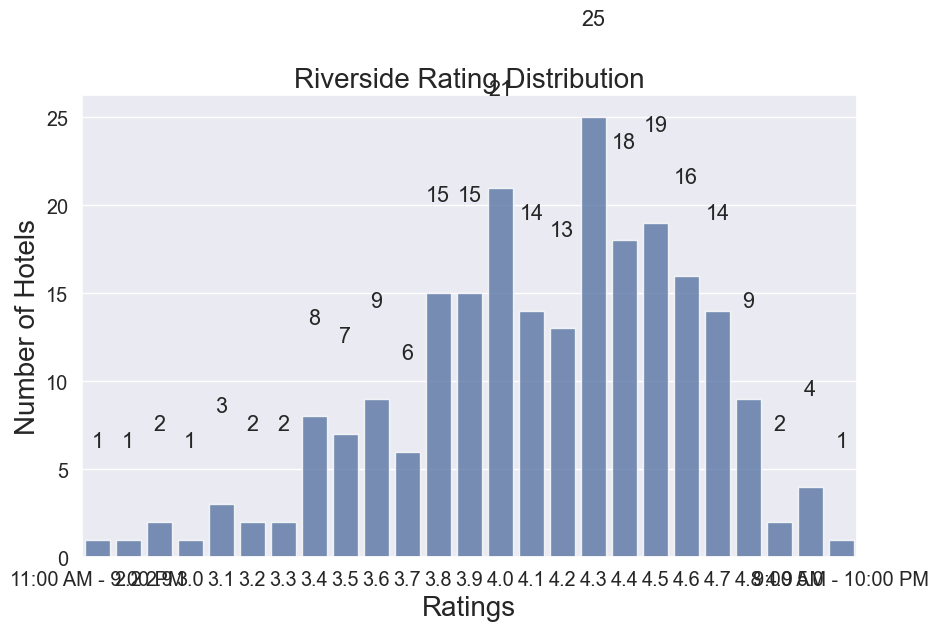

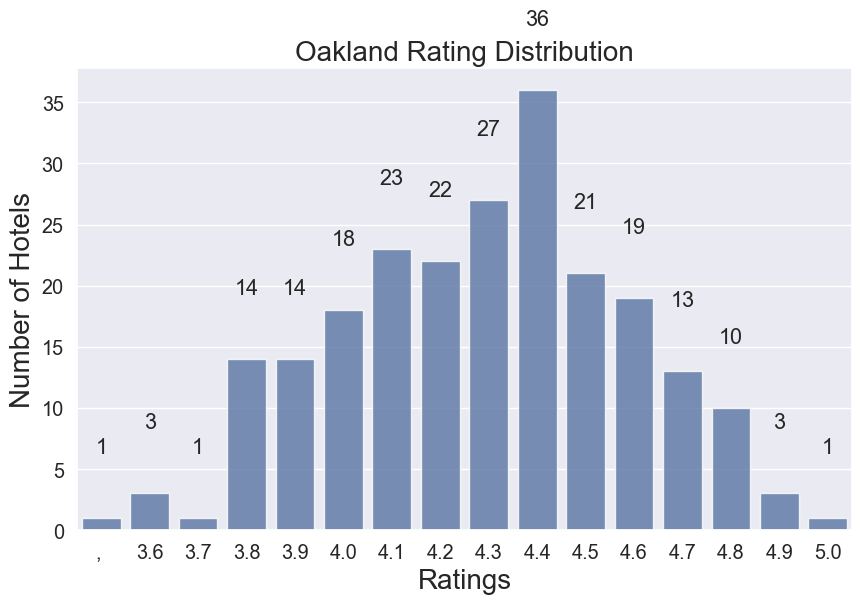

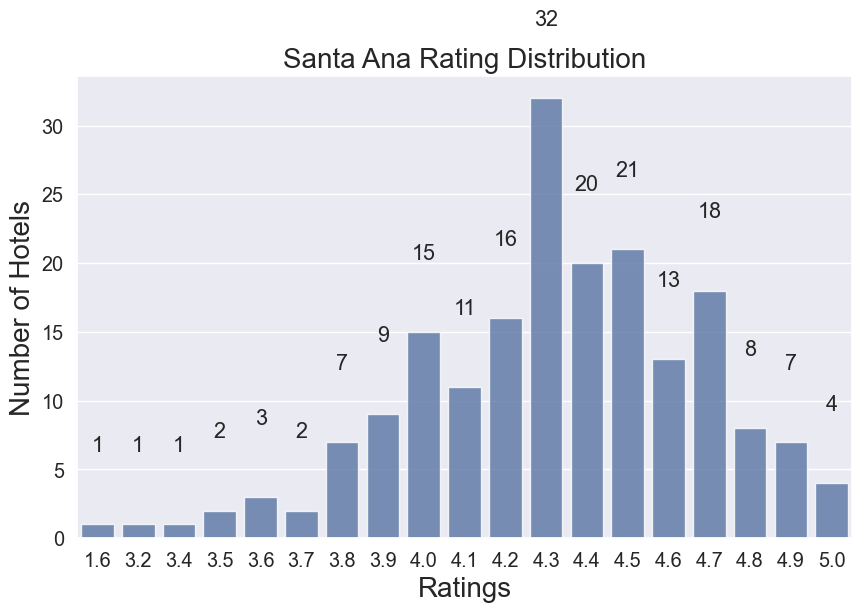

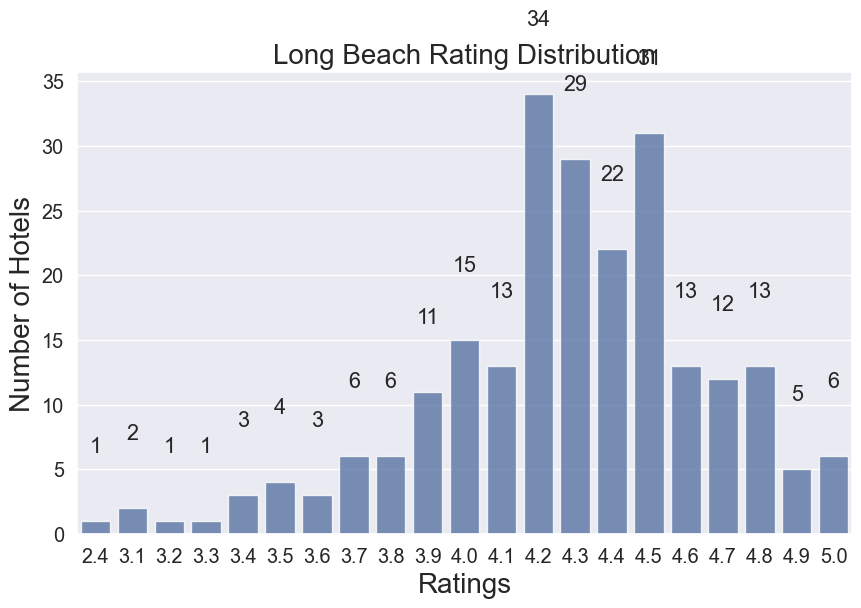

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(25,25)})
sns.set(font_scale=1.3)

# Los Angeles
plt.figure(figsize=(10, 6))
ratdist = RatdistPlot(yelp_df_la)
clean_yelp_df_la = ratdist.clean_each_city_df()
ratdist.plot(20, "Los Angeles Rating Distribution")

# San Diego
plt.figure(figsize=(10, 6))
ratdist = RatdistPlot(yelp_df_sd)
clean_yelp_df_sd = ratdist.clean_each_city_df()
ratdist.plot(20, "San Diego Rating Distribution")

# San Jose
plt.figure(figsize=(10, 6))
ratdist = RatdistPlot(yelp_df_sj)
clean_yelp_df_sj = ratdist.clean_each_city_df()
ratdist.plot(20, "San Jose Rating Distribution")

# San Francisco
plt.figure(figsize=(10, 6))
ratdist = RatdistPlot(yelp_df_sf)
clean_yelp_df_sf = ratdist.clean_each_city_df()
ratdist.plot(20, "San Francisco Rating Distribution")

# Fresno
plt.figure(figsize=(10, 6))
ratdist = RatdistPlot(yelp_df_fr)
clean_yelp_df_fr = ratdist.clean_each_city_df()
ratdist.plot( 20, "Fresno Rating Distribution")

# Sacramento
plt.figure(figsize=(10, 6))
ratdist = RatdistPlot(yelp_df_sc)
clean_yelp_df_sc = ratdist.clean_each_city_df()
ratdist.plot(20, "Sacramento Rating Distribution")

plt.figure(figsize=(10, 6))
ratdist = RatdistPlot(yelp_df_ah)
clean_yelp_df_ah = ratdist.clean_each_city_df()
ratdist.plot(20, "Anahiem Rating Distribution")

plt.figure(figsize=(10, 6))
ratdist = RatdistPlot(yelp_df_bf)
clean_yelp_df_bf = ratdist.clean_each_city_df()
ratdist.plot(20, "Bakersfield Rating Distribution")

plt.figure(figsize=(10, 6))
ratdist = RatdistPlot(yelp_df_rs)
clean_yelp_df_rs = ratdist.clean_each_city_df()
ratdist.plot(20, "Riverside Rating Distribution")

plt.figure(figsize=(10, 6))
ratdist = RatdistPlot(yelp_df_ok)
clean_yelp_df_ok = ratdist.clean_each_city_df()
ratdist.plot(20, "Oakland Rating Distribution")

plt.figure(figsize=(10, 6))
ratdist = RatdistPlot(yelp_df_sa)
clean_yelp_df_sa = ratdist.clean_each_city_df()
ratdist.plot(20, "Santa Ana Rating Distribution")

plt.figure(figsize=(10, 6))
ratdist = RatdistPlot(yelp_df_lb)
clean_yelp_df_lb = ratdist.clean_each_city_df()
ratdist.plot(20, "Long Beach Rating Distribution")
plt.show()


## Data VIZ

In [140]:
import pandas as pd
import sys
import numpy as np
import os
import nltk
import string
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 
from nltk.corpus import stopwords
from helper_fe import *

# Set up nltk stopwords
nltk.download('stopwords')

class CategoryPlot:
    
    def __init__(self, data, remove=string.punctuation):
        self.pattern = fr"[{remove}]"
        self.cat_frequency = {}
        self.data = data
        
    def _regex_split_join(self, item):
        """ Statistics on word frequency by attributes """
        try:
            to_be_join = re.split(self.pattern, item.strip())
        except:
            raise Exception(f'The item --{item} in the line above is not a string')
        for word in to_be_join:
            new_word = word.strip()
            if new_word in self.cat_frequency:
                self.cat_frequency[new_word] += 1
            else:
                self.cat_frequency[new_word] = 1
        return " ".join(to_be_join)
    
    def category_counting(self):
        """ Apply count frequency """
        self.data[['Category']].applymap(self._regex_split_join)  # Deep copy
        del self.cat_frequency['Unknown']  # Drop the "Unknown" case
        if '' in self.cat_frequency:
            del self.cat_frequency['']  # Drop the "" case
        return self.cat_frequency
    
    def cat_plot(self, num_top, font_size, title, overall=False, verbose=False):
        """ Frequency bar plot """
        catfre_df = pd.DataFrame(self.cat_frequency.items(), columns=['Word_Categories', 'Frequency'])
        # Sort the dataframe by word frequency 
        catfre_df = catfre_df.sort_values('Frequency', ascending=False)
        tot_cat = catfre_df.Word_Categories.value_counts()
        if verbose:
            print(f"There are {len(tot_cat)} different word categories to describe restaurants in Yelp")

        top_cat = catfre_df.Word_Categories.iloc[0:num_top]
        top_fre = catfre_df.Frequency.iloc[0:num_top]
        if overall:
            plt.figure(figsize=(20, 14))
        ax = sns.barplot(x=top_fre.values, y=top_cat.values, alpha=0.8)
        plt.title(title, fontsize=font_size)
        plt.ylabel('Word Categories', fontsize=font_size)
        plt.xlabel('Word Frequency', fontsize=font_size)

        # Adding the text labels
        for rect, label in zip(ax.patches, top_fre.values):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() + 5, height / 2 + rect.get_y(), label, ha='left')
            
    def make_word_cloud(self, text, max_word=30):
        """ Generate word cloud by word frequency """
        wordcloud = WordCloud(
            background_color='white',
            stopwords=stopwords.words("english"),
            scale=10,
            max_words=max_word,
            max_font_size=40)
        wordcloud = wordcloud.generate_from_frequencies(frequencies=self.cat_frequency)
        plt.figure(1, figsize=(15, 15))
        plt.axis('off')
        plt.imshow(wordcloud, interpolation="bilinear")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akhilvelamati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


There are 229 different word categories to describe restaurants in Yelp


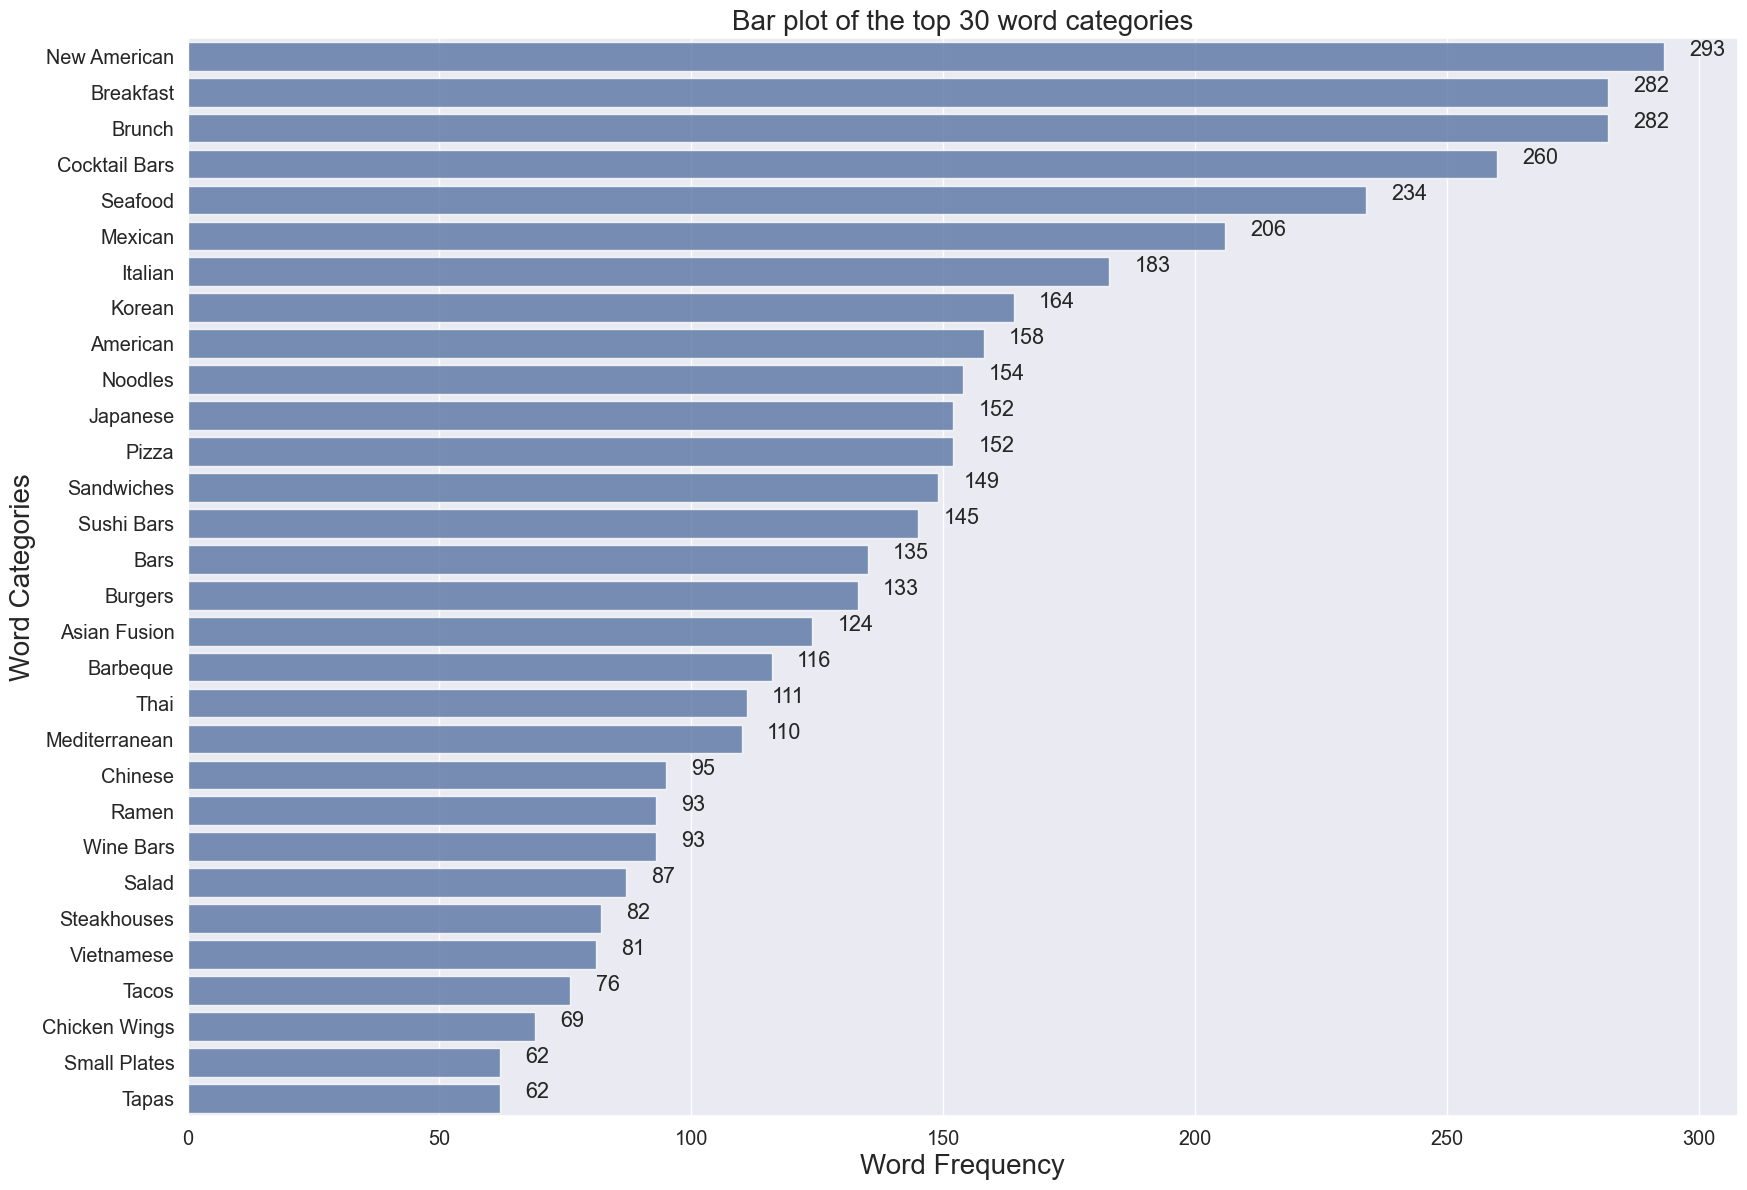

In [141]:
# apply to all dataset 
sns.set(rc={'figure.figsize':(25,25)})
sns.set(font_scale=1.3)
category_plot = CategoryPlot(yelp_clean_df)
category_plot.category_counting()
category_plot.cat_plot(30, 20, "Bar plot of the top 30 word categories", overall=True, verbose=True)

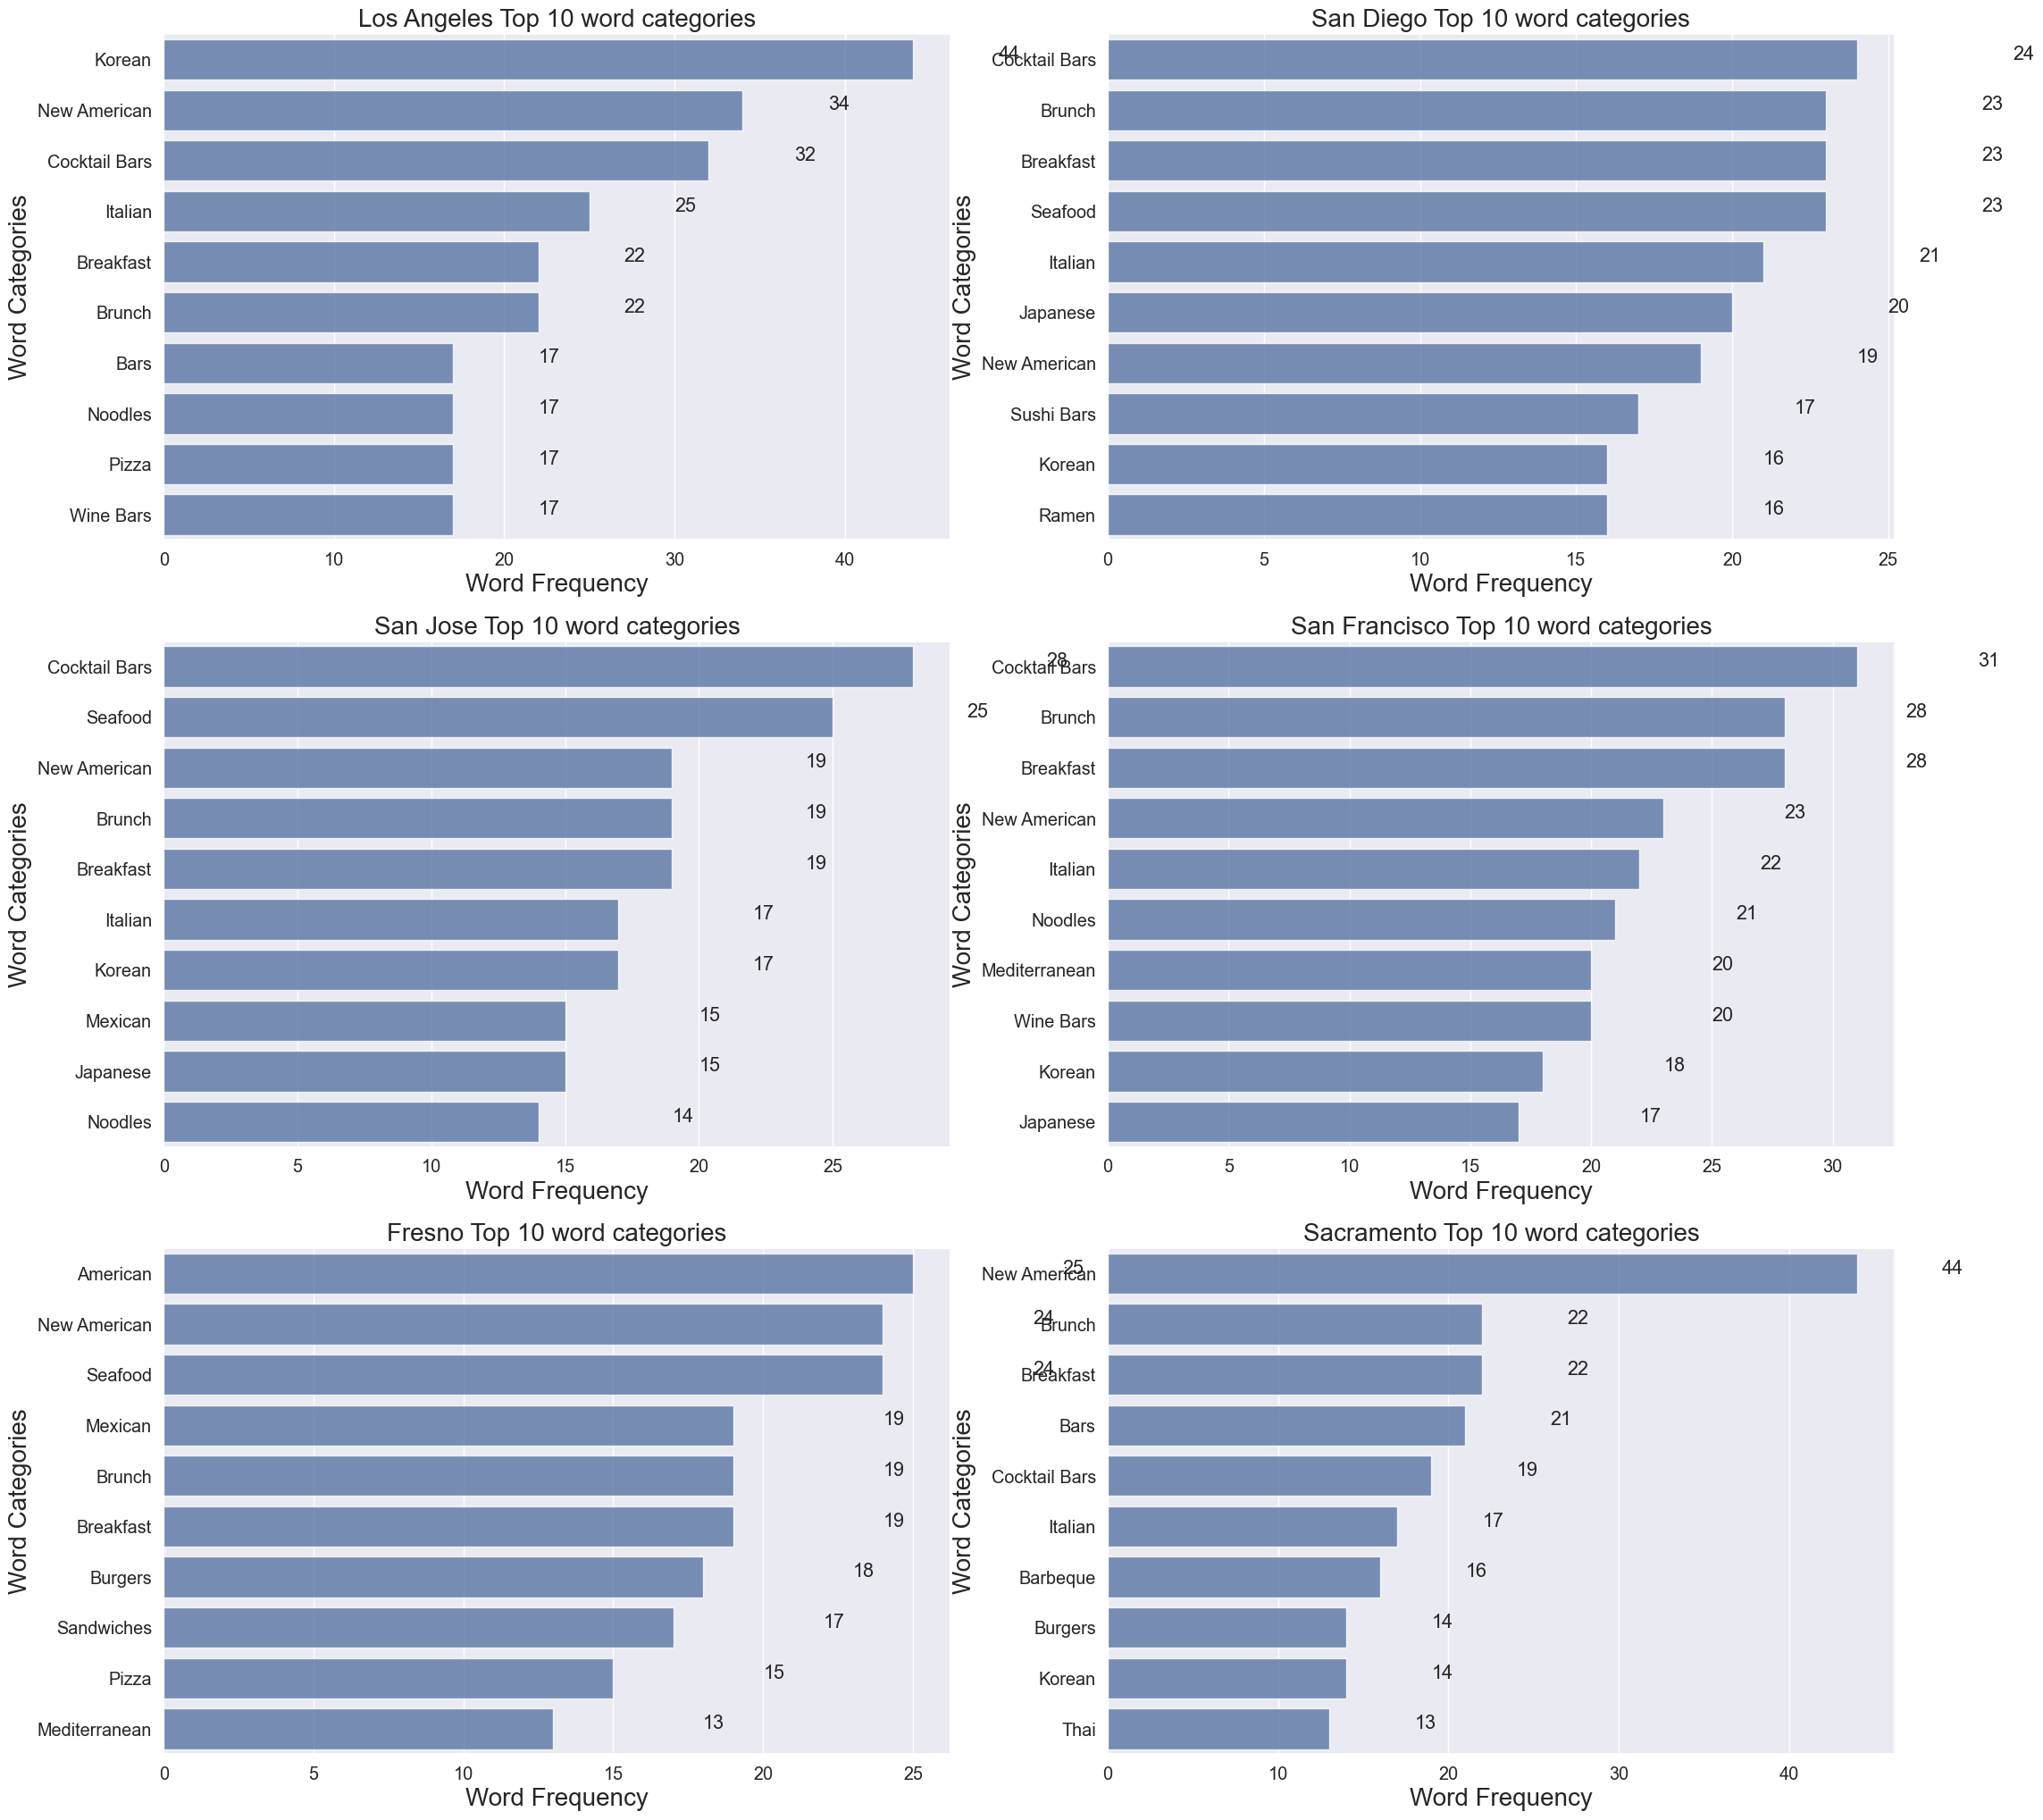

In [142]:
# 12 top 10 words plots
sns.set(font_scale=1.3)

# Los Angeles
plt.subplot(321)
category_plot = CategoryPlot(clean_yelp_df_la)
category_plot.category_counting()
category_plot.cat_plot(10, 20, "Los Angeles Top 10 word categories")

# San Diego
plt.subplot(322)
category_plot = CategoryPlot(clean_yelp_df_sd)
category_plot.category_counting()
category_plot.cat_plot(10, 20, "San Diego Top 10 word categories")

# San Jose
plt.subplot(323)
category_plot = CategoryPlot(clean_yelp_df_sj)
category_plot.category_counting()
category_plot.cat_plot(10, 20, "San Jose Top 10 word categories")

# San Francisco
plt.subplot(324)
category_plot = CategoryPlot(clean_yelp_df_sf)
category_plot.category_counting()
category_plot.cat_plot(10, 20, "San Francisco Top 10 word categories")

# Fresno
plt.subplot(325)
category_plot = CategoryPlot(clean_yelp_df_fr)
category_plot.category_counting()
category_plot.cat_plot(10, 20, "Fresno Top 10 word categories")

# Sacramento
plt.subplot(326)
category_plot = CategoryPlot(clean_yelp_df_sc)
category_plot.category_counting()
category_plot.cat_plot(10, 20, "Sacramento Top 10 word categories")

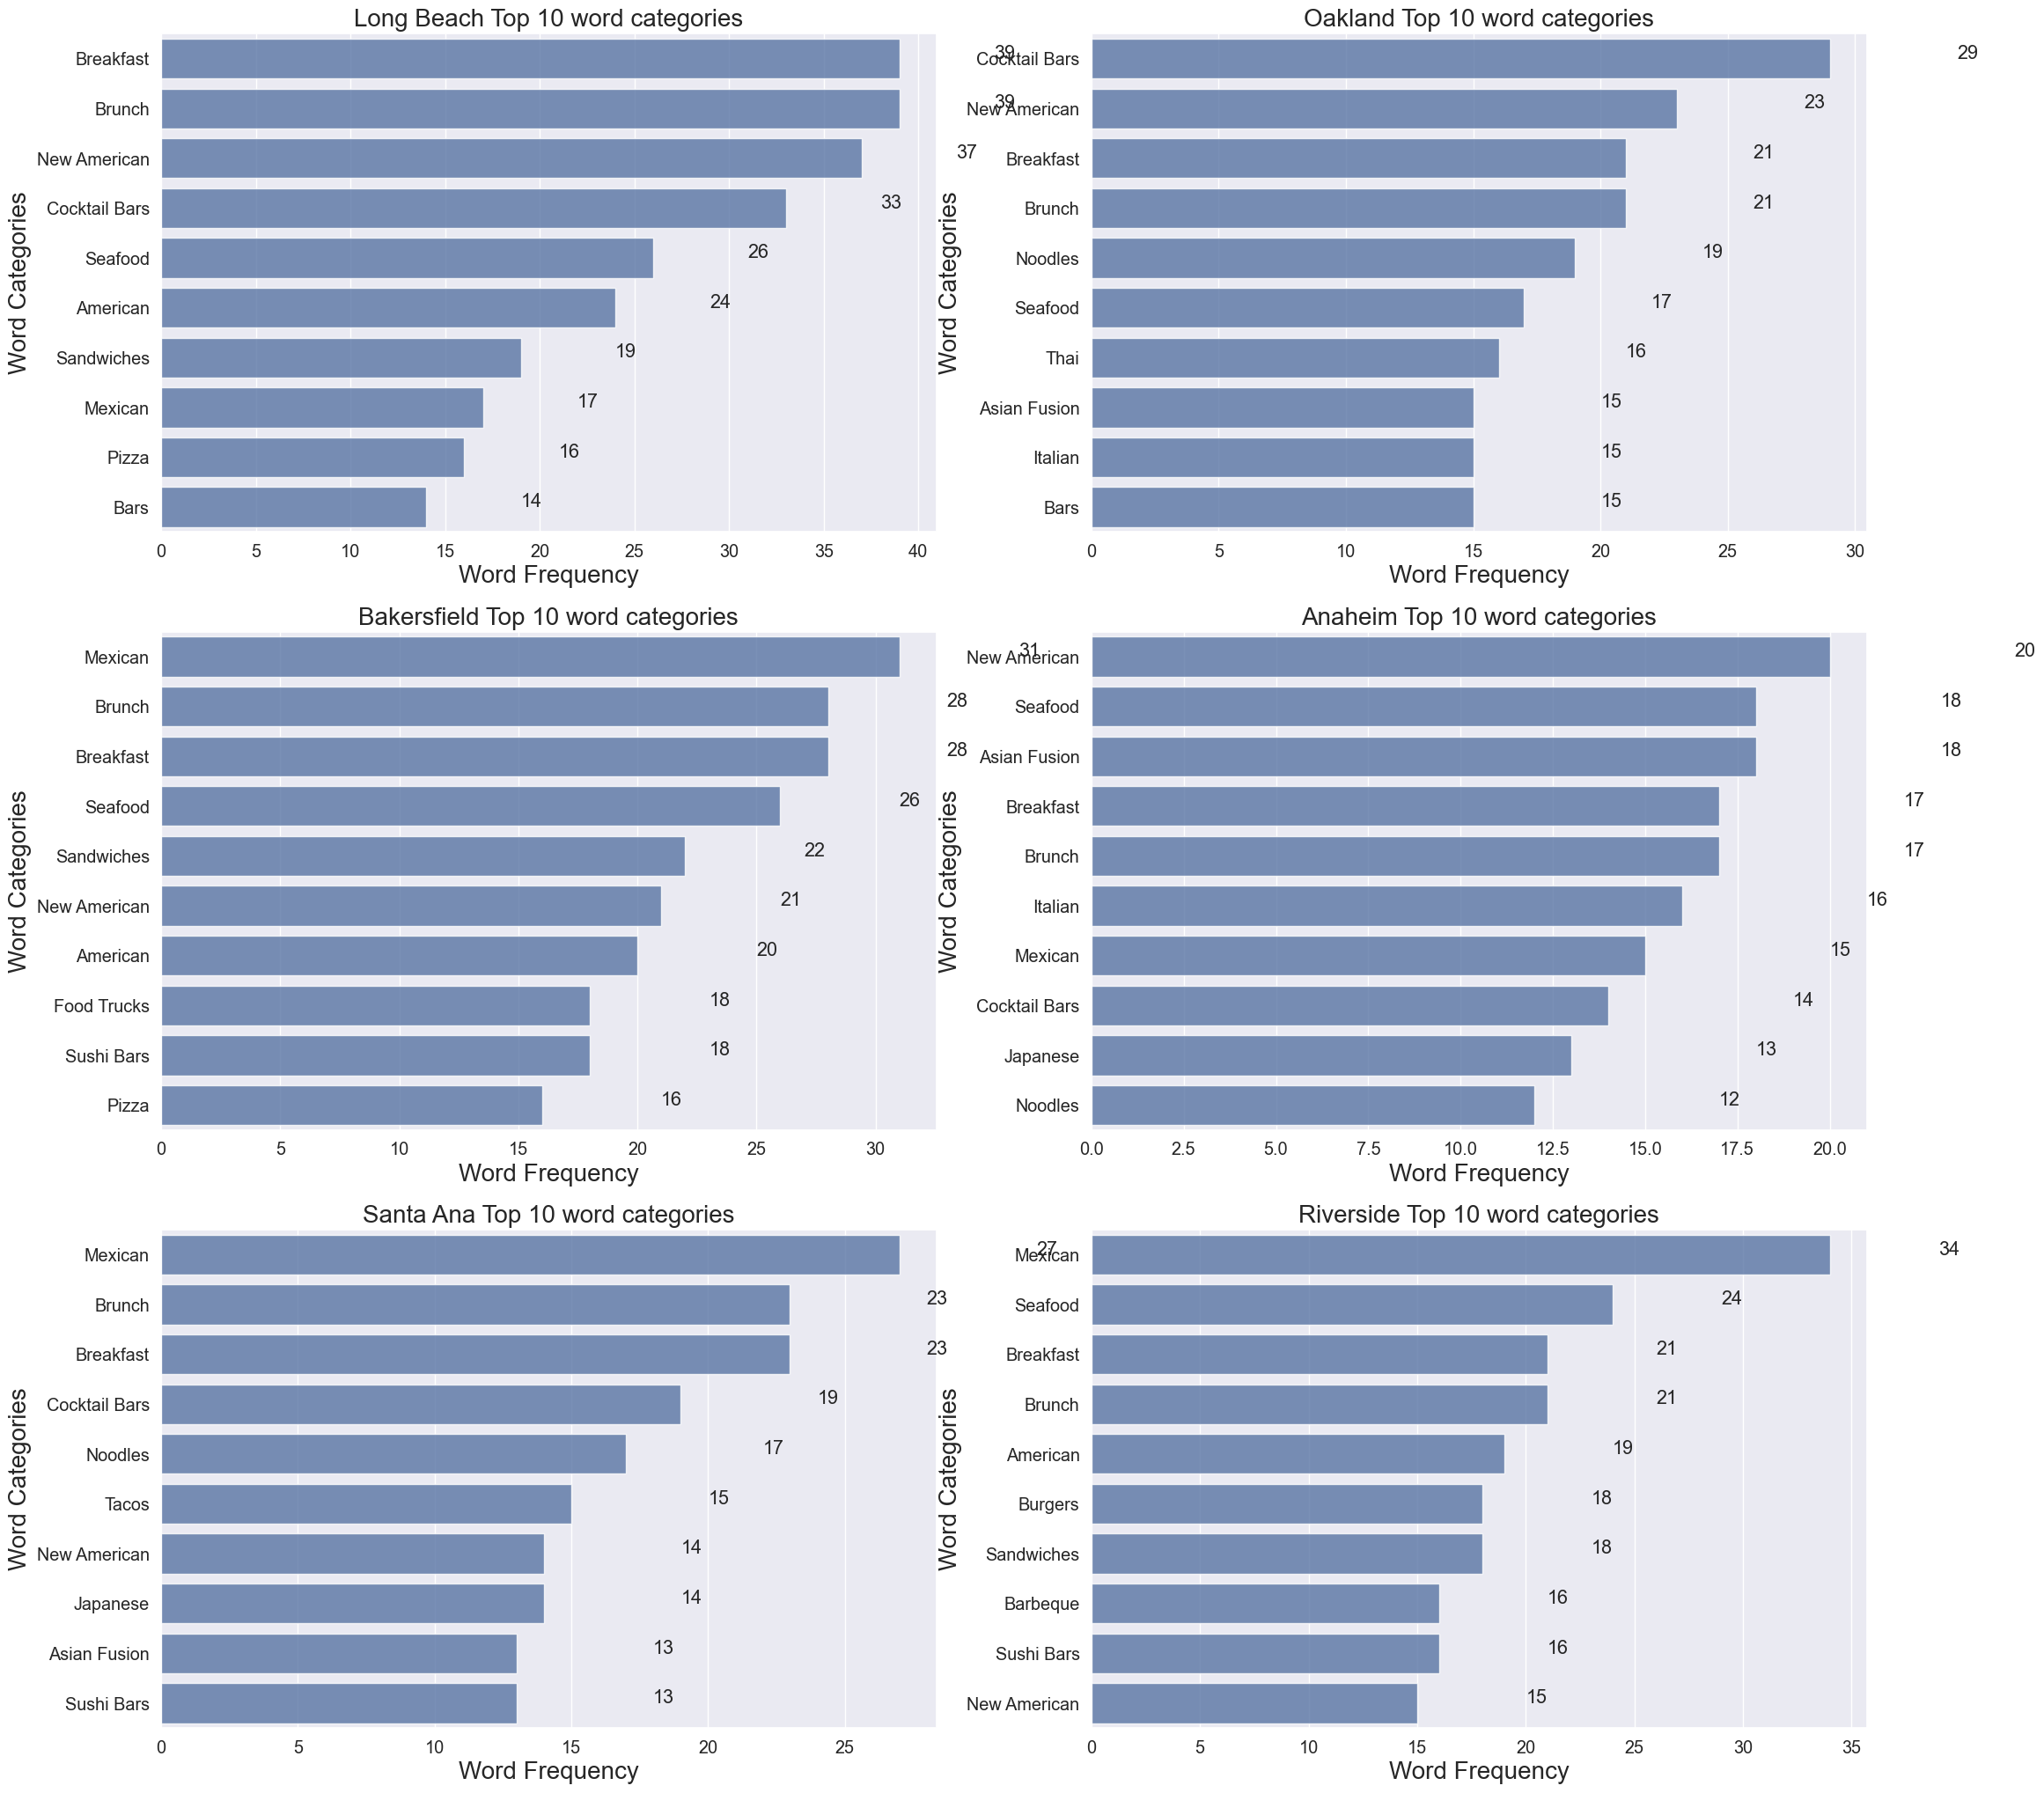

In [143]:
# Long Beach
plt.subplot(321)
category_plot = CategoryPlot(clean_yelp_df_lb)
category_plot.category_counting()
category_plot.cat_plot(10, 20, "Long Beach Top 10 word categories")

# Oakland
plt.subplot(322)
category_plot = CategoryPlot(clean_yelp_df_ok)
category_plot.category_counting()
category_plot.cat_plot(10, 20, "Oakland Top 10 word categories")

# Bakersfield
plt.subplot(323)
category_plot = CategoryPlot(clean_yelp_df_bf)
category_plot.category_counting()
category_plot.cat_plot(10, 20, "Bakersfield Top 10 word categories")

# Anaheim
plt.subplot(324)
category_plot = CategoryPlot(clean_yelp_df_ah)
category_plot.category_counting()
category_plot.cat_plot(10, 20, "Anaheim Top 10 word categories")

# Santa Ana
plt.subplot(325)
category_plot = CategoryPlot(clean_yelp_df_sa)
category_plot.category_counting()
category_plot.cat_plot(10, 20, "Santa Ana Top 10 word categories")

# Riverside
plt.subplot(326)
category_plot = CategoryPlot(clean_yelp_df_rs)
category_plot.category_counting()
category_plot.cat_plot(10, 20, "Riverside Top 10 word categories")

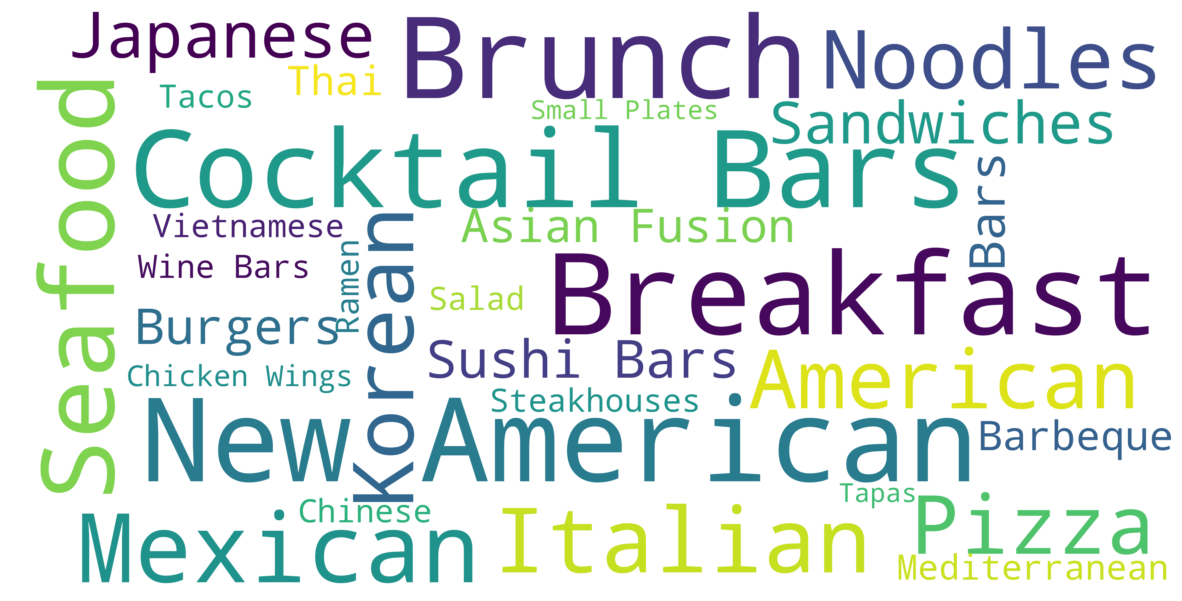

In [144]:
# word cloud plot on cancat dataset
category_plot = CategoryPlot(yelp_clean_df)
category_plot.category_counting()
cats_txt_list = yelp_clean_df['Category'].to_string()  # extract text
category_plot.make_word_cloud(cats_txt_list)

## Restaurant Operating Hour Analysis

In [154]:
class OpHrsPlot:
    
    def __init__(self, df):
        self.df = df
        
    def add_hours_feature(self):
        """ add 14 new features about open and close time for all restaurants in given dataframe 
        based on original weekdays features
        """
        self.df[['MonOpen', 'TueOpen', 'WedOpen', 'ThuOpen', 'FriOpen', 'SatOpen',
            'SunOpen']] = self.df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].applymap(OpeningTime)
        self.df[['MonClose', 'TueClose', 'WedClose', 'ThuClose', 'FriClose', 'SatClose',
            'SunClose']] = self.df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].applymap(ClosingTime)
        return self.df
    
    def box_plot(self, font_size, title):
        """ make ratings distribution plot
        for open hours analysis 
        """
        clean_df_sub = self.df[['MonOpen', 'TueOpen', 'WedOpen', 'ThuOpen', 'FriOpen', 'SatOpen', 'SunOpen']]
        ax = sns.boxplot(data=clean_df_sub)
        plt.title(title, fontsize=font_size)
        plt.xlabel("Operation Hours", fontsize=font_size)
        plt.ylabel("Week days", fontsize=font_size)
        
    def cat_plot(self, font_size, title):
        clean_df_sub = self.df[['MonOpen', 'TueOpen', 'WedOpen', 'ThuOpen', 'FriOpen', 'SatOpen', 'SunOpen']]
        ax = sns.countplot(data=clean_df_sub, x='Category', hue='Weekday')
        plt.title(title, fontsize=font_size)
        plt.xlabel("Category", fontsize=font_size)
        plt.ylabel("Count", fontsize=font_size)
    
    def violin_plot(self, font_size, title):
        """ make ratings distribution plot 
        for close hours analysis 
        """
        clean_df_sub = self.df[['MonClose', 'TueClose', 'WedClose', 'ThuClose', 'FriClose', 'SatClose', 'SunClose']]
        ax = sns.violinplot(data=clean_df_sub)
        plt.title(title, fontsize=font_size)
        plt.xlabel("Operation Hours", fontsize=font_size)
        plt.ylabel("Week days", fontsize=font_size)

Actual string [['11:30 AM ', ' 9:00 PM']]
time_str: ['11:30', 'AM']
Opening component: <class 'str'>
Actual string [['8:00 AM ', ' 10:00 PM']]
time_str: ['8:00', 'AM']
Opening component: <class 'str'>
Actual string [['4:00 PM ', ' 10:00 PM']]
time_str: ['4:00', 'PM']
Opening component: <class 'str'>
Actual string [['4:00 PM ', ' 12:00 AM (Next day)']]
time_str: ['4:00', 'PM']
Opening component: <class 'str'>
Actual string [['8:00 AM ', ' 2:00 PM']]
time_str: ['8:00', 'AM']
Opening component: <class 'str'>
Actual string [['10:00 AM ', ' 9:00 PM']]
time_str: ['10:00', 'AM']
Opening component: <class 'str'>
Actual string [['3:00 PM ', ' 1:00 AM (Next day)']]
time_str: ['3:00', 'PM']
Opening component: <class 'str'>
Actual string [['11:00 AM ', ' 3:00 PM']]
time_str: ['11:00', 'AM']
Opening component: <class 'str'>
Actual string [['11:30 AM ', ' 3:00 PM']]
time_str: ['11:30', 'AM']
Opening component: <class 'str'>
Actual string [[0, 24]]
time_str: ['0']
Opening component: <class 'str'>
Act

ValueError: Could not interpret value `Category` for `x`. An entry with this name does not appear in `data`.

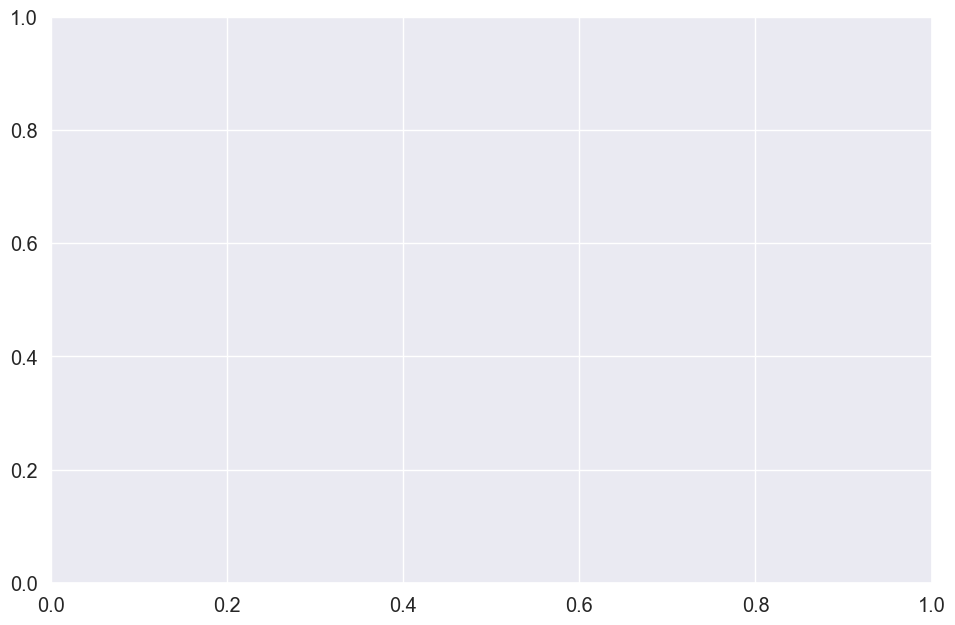

In [155]:
# 12 cities' restaurants open hours boxplots
sns.set(rc={'figure.figsize':(25, 25)})
sns.set(font_scale=1.3)

# Los Angeles
plt.subplot(321)
ophrs_plot = OpHrsPlot(clean_yelp_df_la)
ophrs_plot.add_hours_feature()
ophrs_plot.cat_plot(20, "Los Angeles restaurants open hours distribution")

# San Diego
plt.subplot(322)
ophrs_plot = OpHrsPlot(clean_yelp_df_sd)
ophrs_plot.add_hours_feature()
ophrs_plot.box_plot(20, "San Diego restaurants open hours distribution")

# San Jose
plt.subplot(323)
ophrs_plot = OpHrsPlot(clean_yelp_df_sj)
ophrs_plot.add_hours_feature()
ophrs_plot.box_plot(20, "San Jose restaurants open hours distribution")

# San Francisco
plt.subplot(324)
ophrs_plot = OpHrsPlot(clean_yelp_df_sf)
ophrs_plot.add_hours_feature()
ophrs_plot.box_plot(20, "San Francisco restaurants open hours distribution")

# Fresno
plt.subplot(325)
ophrs_plot = OpHrsPlot(clean_yelp_df_fr)
ophrs_plot.add_hours_feature()
ophrs_plot.box_plot(20, "Fresno restaurants open hours distribution")

# Sacramento
plt.subplot(326)
ophrs_plot = OpHrsPlot(clean_yelp_df_sc)
ophrs_plot.add_hours_feature()
ophrs_plot.box_plot(20, "Sacramento restaurants open hours distribution")